# Music League Analysis - Welcome my 5-4 Friends

Before running after a while, refresh spotify oAuth token here: https://developer.spotify.com/console/get-audio-features-several-tracks/?ids=7ouMYWpwJ422jRcDASZB7P%2C4VqPOruhp5EdPBeR92t6lQ%2C2takcwOaAZWiXQijPHIx7B

# Ideas and log

### DONE: 
1. also maybe agreement scoring? similarity in voting behavior between 2 people
2. Melissa- what would happen if you divided the total number of points each person to times given points
3. percent to each other
4. [0s without Comments][0s with comments][Votes without comments][Votes with comments]
5. pull in spotify feature data for every song
6. Cluster analysis + chart that shows percent commented on vs. percent voted for
7. How spotify features track over rounds

### DOING: 
0. person level feature correlations
1. genre dendogram against points received

### UP NEXT
0. Person points predictions
1. how often do you place high vs. place low (hard because num copmetitors changes in each round...)
2. points above replacement submission
    a. Look at the median submission for each round
    b. subtract that from your submission each round
    c. sum per voter
    d. divide by number of rounds participated in
3. % of your votes that went to the bottom 3 of each round (clout chaser)
4. % of your votes that went to the top 3 of each round (good samaritans)

### EH:
1. sort by created date
2. who gets points from the same people

### NOT DOING: 
1. clusters of who you give votes to: so many people vote for everyone at times


In [1]:
#!git clone https://github.com/clydeiii/musicleague.git
#I guess only do this if you move the folder and need to recreate it? who knows

# 0. Installing Plugins
## put all the pips back in on a new device I guess

In [2]:
#!pip install mpld3
#!pip install mplcursors
#!pip install watermark
#!pip install spotipy
#!pip install tekore
#!pip install --upgrade jupyterlab ipympl

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
#from math import log10, floor
#from numpy import dot
#from numpy.linalg import norm
import nltk
import time
import sklearn
from sklearn.cluster import KMeans
from numpy import array
import plotly.express as px
import mpld3
#from mpld3.utils import get_id
#import collections
import mplcursors
from mpld3 import plugins
import matplotlib.pyplot as plt, mpld3
import watermark
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import plotly.graph_objects as go
import plotly.offline as pyo

In [4]:
#!pip install spotipy
#!pip install tekore
#!pip install --upgrade jupyterlab ipympl

In [5]:
cid = 'f94e93955e944be5a8fb01f8e04a012a'
secret = '711f7f8a8f4d48e08c4154c23cf2c2bc'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

spotify = spotipy.Spotify(auth=cid, requests_timeout=10, retries=10)

# client id = f94e93955e944be5a8fb01f8e04a012a
# client secret = 711f7f8a8f4d48e08c4154c23cf2c2bc
# oauth token = BQB5vc8WqGzFaCdB-O7VgUNT8aKZq-WP_1yGEtiD-2htGaM2XemlzbiLGoxhBDN8nCF7wiQIYvzSxbDWLa_PNWc_399i3JW7oNHCxGn7Bwcpl8pqrlYvOsxivUXtXK7XpKGFKKk_sI6fr3EV2GMIupmRU3YZuj4AMYLCdvNnnpE


# 1. Import Raw Data  
## This pulls in the songs, round names, and combines into voting habits of everyone, per round

In [6]:
# Read in the exported csv files 
path = 'musicleague/data/%s'
competitors = pd.read_csv(path % ('competitors.csv'))
rounds = pd.read_csv(path % ('rounds.csv'))
submissions = pd.read_csv(path % ('submissions.csv'))
votes = pd.read_csv(path % ('votes.csv'))
#rounds_url = "https://github.com/jackfleming0/musicleague/blob/main/data/rounds.csv"
#submissions_url = "https://github.com/jackfleming0/musicleague/blob/main/data/submissions.csv"
#votes_url = "https://github.com/jackfleming0/musicleague/blob/main/data/votes.csv"
#competitors_url = "https://github.com/jackfleming0/musicleague/blob/main/data/competitors.csv"
#rounds = pd.read_csv(rounds_url)
#submissions = pd.read_csv(submissions_url)
#votes = pd.read_csv(votes_url)
#competitors = pd.read_csv(competitors_url)
votes = pd.merge(votes, competitors, how='left', left_on=['Voter ID'], right_on = ['ID'])
submissions = pd.merge(submissions, competitors, how='left', left_on=['Submitter ID'], right_on = ['ID'])

# Join the votes with who submitted
vote_and_submissions = pd.merge(votes, submissions, suffixes = ("_voter", "_submitter"), how='left', left_on=['Round ID','Spotify URI'], right_on = ['Round ID','Spotify URI'])
vote_and_submissions.columns = vote_and_submissions.columns.str.replace(' ','_')
vote_and_submissions = vote_and_submissions.sort_values(by='Round_ID')

# Group the votes by the voter. Calculate both the count of votes and sum of the votes. Also do average
votes_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
points_for = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).sum()
votes_cast = vote_and_submissions.groupby('Name_voter').sum()
#average_vote = vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).mean()

# 2. Spotify API Calls 
## Here, we call the spotify API to get "features" for every song submitted.
Features are things like "danceability," where I don't have a lot of insight into their creation. Interesting idea though!

In [7]:
#creating a df for song IDs (grouped by round ID as well in case same songs come up across the league)
#once created, I'll use this for a better picture of the 'types' of songs submitted

song_feature_analysis = vote_and_submissions.groupby(['Spotify_URI', 'Round_ID']).sum('Points_Assigned')


#adding the features to the spreadsheet
song_feature_analysis['danceability']=""
song_feature_analysis['energy']=""
song_feature_analysis['key']=""
song_feature_analysis['loudness']=""
song_feature_analysis['mode']=""
song_feature_analysis['speechiness']=""
song_feature_analysis['acousticness']=""
song_feature_analysis['instrumentalness']=""
song_feature_analysis['liveness']=""
song_feature_analysis['valence']=""
song_feature_analysis['tempo']=""
song_feature_analysis['duration_ms']=""
song_feature_analysis['time_signature']=""

song_feature_analysis = song_feature_analysis.reset_index()

In [8]:
#this function gets looped through a bit later
#it look like calls the API and get a list of values, and then convert that into a temporary df. 
#then, it merges that temporary df, column by column, into song_feature_analysis 

def song_feature_ascriber(row, loop_URI):
    loop_features_df = pd.DataFrame(sp.audio_features(loop_URI))
    
    #add attributes
    song_feature_analysis.at[row, 'danceability'] = loop_features_df.iat[0,0]
    song_feature_analysis.at[row, 'energy'] = loop_features_df.iat[0,1]
    song_feature_analysis.at[row, 'key'] = loop_features_df.iat[0,2]
    song_feature_analysis.at[row, 'loudness'] = loop_features_df.iat[0,3]
    song_feature_analysis.at[row, 'mode'] = loop_features_df.iat[0,4]
    song_feature_analysis.at[row, 'speechiness'] = loop_features_df.iat[0,5]
    song_feature_analysis.at[row, 'acousticness'] = loop_features_df.iat[0,6]
    song_feature_analysis.at[row, 'instrumentalness'] = loop_features_df.iat[0,7]
    song_feature_analysis.at[row, 'liveness'] = loop_features_df.iat[0,8]
    song_feature_analysis.at[row, 'valence'] = loop_features_df.iat[0,9]
    song_feature_analysis.at[row, 'tempo'] = loop_features_df.iat[0,10]
    song_feature_analysis.at[row, 'duration_ms'] = loop_features_df.iat[0,16]
    song_feature_analysis.at[row, 'time_signature'] = loop_features_df.iat[0,17]

In [10]:
#using the row count to create a forloop to fill in columns of song_feature_analysis
#probably a faster way to do this, given it takes a minute for 576 songs... 

startTime = time.time()

total_song_count = len(song_feature_analysis.index)

for x in range (0,total_song_count):
    song_feature_ascriber(x,song_feature_analysis.at[x,'Spotify_URI'])
    
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))



Execution time in seconds: 90.10104990005493


# 2.1 Get all song titles
Mostly keeping this inactive except when needed. takes too long

In [95]:
all_songs_submitted_info = pd.DataFrame
x=0
for x in range (0,total_song_count):
    z = sp.track((song_feature_analysis).at[x,'Spotify_URI'])
    print(z['name'])
    print(z['artists'])

I Kissed A Girl
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6jJ0s89eD6GaHleKKya26X'}, 'href': 'https://api.spotify.com/v1/artists/6jJ0s89eD6GaHleKKya26X', 'id': '6jJ0s89eD6GaHleKKya26X', 'name': 'Katy Perry', 'type': 'artist', 'uri': 'spotify:artist:6jJ0s89eD6GaHleKKya26X'}]
薔薇と野獣 - new ver.
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/370nbSkMB9kDWyTypwWYak'}, 'href': 'https://api.spotify.com/v1/artists/370nbSkMB9kDWyTypwWYak', 'id': '370nbSkMB9kDWyTypwWYak', 'name': 'Haruomi Hosono', 'type': 'artist', 'uri': 'spotify:artist:370nbSkMB9kDWyTypwWYak'}]
Paradise
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3vDpQbGnzRbRVirXlfQagB'}, 'href': 'https://api.spotify.com/v1/artists/3vDpQbGnzRbRVirXlfQagB', 'id': '3vDpQbGnzRbRVirXlfQagB', 'name': 'Sturgill Simpson', 'type': 'artist', 'uri': 'spotify:artist:3vDpQbGnzRbRVirXlfQagB'}]
L.I.N.E.
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1bwUhKRmEkOZ1wuTnV9XjC'}, 'href': '

Fitness
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/56oDRnqbIiwx4mymNEv7dS'}, 'href': 'https://api.spotify.com/v1/artists/56oDRnqbIiwx4mymNEv7dS', 'id': '56oDRnqbIiwx4mymNEv7dS', 'name': 'Lizzo', 'type': 'artist', 'uri': 'spotify:artist:56oDRnqbIiwx4mymNEv7dS'}]
What's It Gonna Be?! (feat. Janet Jackson)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1YfEcTuGvBQ8xSD1f53UnK'}, 'href': 'https://api.spotify.com/v1/artists/1YfEcTuGvBQ8xSD1f53UnK', 'id': '1YfEcTuGvBQ8xSD1f53UnK', 'name': 'Busta Rhymes', 'type': 'artist', 'uri': 'spotify:artist:1YfEcTuGvBQ8xSD1f53UnK'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/4qwGe91Bz9K2T8jXTZ815W'}, 'href': 'https://api.spotify.com/v1/artists/4qwGe91Bz9K2T8jXTZ815W', 'id': '4qwGe91Bz9K2T8jXTZ815W', 'name': 'Janet Jackson', 'type': 'artist', 'uri': 'spotify:artist:4qwGe91Bz9K2T8jXTZ815W'}]
Stick Season
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2RQXRUsr4IW1f3mKyKsy4B'}, 'href':

Heaven - Live
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2x9SpqnPi8rlE9pjHBwmSC'}, 'href': 'https://api.spotify.com/v1/artists/2x9SpqnPi8rlE9pjHBwmSC', 'id': '2x9SpqnPi8rlE9pjHBwmSC', 'name': 'Talking Heads', 'type': 'artist', 'uri': 'spotify:artist:2x9SpqnPi8rlE9pjHBwmSC'}]
Judas
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms'}, 'href': 'https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms', 'id': '1HY2Jd0NmPuamShAr6KMms', 'name': 'Lady Gaga', 'type': 'artist', 'uri': 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'}]
Talk that Talk
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7n2Ycct7Beij7Dj7meI4X0'}, 'href': 'https://api.spotify.com/v1/artists/7n2Ycct7Beij7Dj7meI4X0', 'id': '7n2Ycct7Beij7Dj7meI4X0', 'name': 'TWICE', 'type': 'artist', 'uri': 'spotify:artist:7n2Ycct7Beij7Dj7meI4X0'}]
Drift Away
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2DnqqkzzDKm3vAoyHtn8So'}, 'href': 'https://api.spotif

I Cannot Fucking Wait Til Morrissey Dies
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6yJ6QQ3Y5l0s0tn7b0arrO'}, 'href': 'https://api.spotify.com/v1/artists/6yJ6QQ3Y5l0s0tn7b0arrO', 'id': '6yJ6QQ3Y5l0s0tn7b0arrO', 'name': 'JPEGMAFIA', 'type': 'artist', 'uri': 'spotify:artist:6yJ6QQ3Y5l0s0tn7b0arrO'}]
Rage
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2OaHYHb2XcFPvqL3VsyPzU'}, 'href': 'https://api.spotify.com/v1/artists/2OaHYHb2XcFPvqL3VsyPzU', 'id': '2OaHYHb2XcFPvqL3VsyPzU', 'name': 'Rico Nasty', 'type': 'artist', 'uri': 'spotify:artist:2OaHYHb2XcFPvqL3VsyPzU'}]
Born in the U.S.A.
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3eqjTLE0HfPfh78zjh6TqT'}, 'href': 'https://api.spotify.com/v1/artists/3eqjTLE0HfPfh78zjh6TqT', 'id': '3eqjTLE0HfPfh78zjh6TqT', 'name': 'Bruce Springsteen', 'type': 'artist', 'uri': 'spotify:artist:3eqjTLE0HfPfh78zjh6TqT'}]
Treat Me Like A Slut
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3Xt3

Not 4 U
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1m2tY2Q32cp51czUo7SxyZ'}, 'href': 'https://api.spotify.com/v1/artists/1m2tY2Q32cp51czUo7SxyZ', 'id': '1m2tY2Q32cp51czUo7SxyZ', 'name': 'Hey Cowboy!', 'type': 'artist', 'uri': 'spotify:artist:1m2tY2Q32cp51czUo7SxyZ'}]
Touch of Grey - 2013 Remaster
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4TMHGUX5WI7OOm53PqSDAT'}, 'href': 'https://api.spotify.com/v1/artists/4TMHGUX5WI7OOm53PqSDAT', 'id': '4TMHGUX5WI7OOm53PqSDAT', 'name': 'Grateful Dead', 'type': 'artist', 'uri': 'spotify:artist:4TMHGUX5WI7OOm53PqSDAT'}]
COZY
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6vWDO969PvNqNYHIOW5v0m'}, 'href': 'https://api.spotify.com/v1/artists/6vWDO969PvNqNYHIOW5v0m', 'id': '6vWDO969PvNqNYHIOW5v0m', 'name': 'Beyoncé', 'type': 'artist', 'uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'}]
Beautiful Stranger
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0mduJ1WZqoWZwAdzC7wY2p'}, 'href':

Like the Way
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7hJnLLfzUy0oDOtNZF8wUm'}, 'href': 'https://api.spotify.com/v1/artists/7hJnLLfzUy0oDOtNZF8wUm', 'id': '7hJnLLfzUy0oDOtNZF8wUm', 'name': 'Bernhoft', 'type': 'artist', 'uri': 'spotify:artist:7hJnLLfzUy0oDOtNZF8wUm'}]
Resort Island : Can You Feel The Sunshine?
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4ShgdWtm52xvEr8uYmT0V6'}, 'href': 'https://api.spotify.com/v1/artists/4ShgdWtm52xvEr8uYmT0V6', 'id': '4ShgdWtm52xvEr8uYmT0V6', 'name': 'SEGA SOUND TEAM', 'type': 'artist', 'uri': 'spotify:artist:4ShgdWtm52xvEr8uYmT0V6'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/66SWQBUB6cJGBegelsW2sd'}, 'href': 'https://api.spotify.com/v1/artists/66SWQBUB6cJGBegelsW2sd', 'id': '66SWQBUB6cJGBegelsW2sd', 'name': 'Richard Jacques', 'type': 'artist', 'uri': 'spotify:artist:66SWQBUB6cJGBegelsW2sd'}]
Constant Craving
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6W1BHDF0T4a4KYcS

You Are Mine
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0aogyPVqx5tlIkR0BHAehX'}, 'href': 'https://api.spotify.com/v1/artists/0aogyPVqx5tlIkR0BHAehX', 'id': '0aogyPVqx5tlIkR0BHAehX', 'name': 'Wallis Bird', 'type': 'artist', 'uri': 'spotify:artist:0aogyPVqx5tlIkR0BHAehX'}]
Wasting Time (Eternal Summer)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0qqxspZOkbN00bu6DaRIrn'}, 'href': 'https://api.spotify.com/v1/artists/0qqxspZOkbN00bu6DaRIrn', 'id': '0qqxspZOkbN00bu6DaRIrn', 'name': 'Four Year Strong', 'type': 'artist', 'uri': 'spotify:artist:0qqxspZOkbN00bu6DaRIrn'}]
Love The Way You Lie
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7dGJo4pcD2V6oG8kP0tJRR'}, 'href': 'https://api.spotify.com/v1/artists/7dGJo4pcD2V6oG8kP0tJRR', 'id': '7dGJo4pcD2V6oG8kP0tJRR', 'name': 'Eminem', 'type': 'artist', 'uri': 'spotify:artist:7dGJo4pcD2V6oG8kP0tJRR'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/5pKCCKE2ajJHZ9KAiaK11H'}, 'hre

Look At Me Now - Acoustic
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6jlWj6y00bMQt8XoKuCjyZ'}, 'href': 'https://api.spotify.com/v1/artists/6jlWj6y00bMQt8XoKuCjyZ', 'id': '6jlWj6y00bMQt8XoKuCjyZ', 'name': 'Emily King', 'type': 'artist', 'uri': 'spotify:artist:6jlWj6y00bMQt8XoKuCjyZ'}]
Blue Jeans Pizza
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2ZfHMUPrxoZNDTBPHmmdhj'}, 'href': 'https://api.spotify.com/v1/artists/2ZfHMUPrxoZNDTBPHmmdhj', 'id': '2ZfHMUPrxoZNDTBPHmmdhj', 'name': 'moe.', 'type': 'artist', 'uri': 'spotify:artist:2ZfHMUPrxoZNDTBPHmmdhj'}]
Yours Until Tomorrow - Bonus Track
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/01Z8Z9K54zewyP04ZfGLSv'}, 'href': 'https://api.spotify.com/v1/artists/01Z8Z9K54zewyP04ZfGLSv', 'id': '01Z8Z9K54zewyP04ZfGLSv', 'name': 'Irma Thomas', 'type': 'artist', 'uri': 'spotify:artist:01Z8Z9K54zewyP04ZfGLSv'}]
Dendron
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3kzNckjE5FzHQhe

Another Sunny Day
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4I2BJf80C0skQpp1sQmA0h'}, 'href': 'https://api.spotify.com/v1/artists/4I2BJf80C0skQpp1sQmA0h', 'id': '4I2BJf80C0skQpp1sQmA0h', 'name': 'Belle and Sebastian', 'type': 'artist', 'uri': 'spotify:artist:4I2BJf80C0skQpp1sQmA0h'}]
Bassically
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1xcMOgFUM1IYZE22YjCvsL'}, 'href': 'https://api.spotify.com/v1/artists/1xcMOgFUM1IYZE22YjCvsL', 'id': '1xcMOgFUM1IYZE22YjCvsL', 'name': 'Tei Shi', 'type': 'artist', 'uri': 'spotify:artist:1xcMOgFUM1IYZE22YjCvsL'}]
Major Tom
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7ip3CWlgPZbQHvgJpmcGSS'}, 'href': 'https://api.spotify.com/v1/artists/7ip3CWlgPZbQHvgJpmcGSS', 'id': '7ip3CWlgPZbQHvgJpmcGSS', 'name': 'Peter Schilling', 'type': 'artist', 'uri': 'spotify:artist:7ip3CWlgPZbQHvgJpmcGSS'}]
Graceland Too
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1r1uxoy19fzMxunt3ONAkG'}, 'href'

Potato Salad
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4V8LLVI7PbaPR0K2TGSxFF'}, 'href': 'https://api.spotify.com/v1/artists/4V8LLVI7PbaPR0K2TGSxFF', 'id': '4V8LLVI7PbaPR0K2TGSxFF', 'name': 'Tyler, The Creator', 'type': 'artist', 'uri': 'spotify:artist:4V8LLVI7PbaPR0K2TGSxFF'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/13ubrt8QOOCPljQ2FL1Kca'}, 'href': 'https://api.spotify.com/v1/artists/13ubrt8QOOCPljQ2FL1Kca', 'id': '13ubrt8QOOCPljQ2FL1Kca', 'name': 'A$AP Rocky', 'type': 'artist', 'uri': 'spotify:artist:13ubrt8QOOCPljQ2FL1Kca'}]
Amor Prohibido
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6IE6z7DcZIT4Ml3Fh5Ivch'}, 'href': 'https://api.spotify.com/v1/artists/6IE6z7DcZIT4Ml3Fh5Ivch', 'id': '6IE6z7DcZIT4Ml3Fh5Ivch', 'name': 'Selena', 'type': 'artist', 'uri': 'spotify:artist:6IE6z7DcZIT4Ml3Fh5Ivch'}]
People Verses
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0o7WWONtleH6PWLn5GIoCM'}, 'href': 'https://api.spot

The Roof (Back In Time) - Mobb Deep Extended Version
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iHNK0tOyZPYnBU7nGAgpQ'}, 'href': 'https://api.spotify.com/v1/artists/4iHNK0tOyZPYnBU7nGAgpQ', 'id': '4iHNK0tOyZPYnBU7nGAgpQ', 'name': 'Mariah Carey', 'type': 'artist', 'uri': 'spotify:artist:4iHNK0tOyZPYnBU7nGAgpQ'}]
Surf Wax America
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3jOstUTkEu2JkjvRdBA5Gu'}, 'href': 'https://api.spotify.com/v1/artists/3jOstUTkEu2JkjvRdBA5Gu', 'id': '3jOstUTkEu2JkjvRdBA5Gu', 'name': 'Weezer', 'type': 'artist', 'uri': 'spotify:artist:3jOstUTkEu2JkjvRdBA5Gu'}]
You are the Problem Here
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/21egYD1eInY6bGFcniCRT1'}, 'href': 'https://api.spotify.com/v1/artists/21egYD1eInY6bGFcniCRT1', 'id': '21egYD1eInY6bGFcniCRT1', 'name': 'First Aid Kit', 'type': 'artist', 'uri': 'spotify:artist:21egYD1eInY6bGFcniCRT1'}]
When You're Old and Lonely
[{'external_urls': {'spotify': 'https

Some Things Never Seem To Fucking Work
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2auiVi8sUZo17dLy1HwrTU'}, 'href': 'https://api.spotify.com/v1/artists/2auiVi8sUZo17dLy1HwrTU', 'id': '2auiVi8sUZo17dLy1HwrTU', 'name': 'Solange', 'type': 'artist', 'uri': 'spotify:artist:2auiVi8sUZo17dLy1HwrTU'}]
Deceptacon
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3luTTVEo8lot6jsdYXdbDN'}, 'href': 'https://api.spotify.com/v1/artists/3luTTVEo8lot6jsdYXdbDN', 'id': '3luTTVEo8lot6jsdYXdbDN', 'name': 'Jessica Hernandez and the Deltas', 'type': 'artist', 'uri': 'spotify:artist:3luTTVEo8lot6jsdYXdbDN'}]
Don't Take The Money (feat. Lorde) - MTV Unplugged
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2eam0iDomRHGBypaDQLwWI'}, 'href': 'https://api.spotify.com/v1/artists/2eam0iDomRHGBypaDQLwWI', 'id': '2eam0iDomRHGBypaDQLwWI', 'name': 'Bleachers', 'type': 'artist', 'uri': 'spotify:artist:2eam0iDomRHGBypaDQLwWI'}, {'external_urls': {'spotify': 'https://op

Shake It Out - MTV Unplugged, 2012
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1moxjboGR7GNWYIMWsRjgG'}, 'href': 'https://api.spotify.com/v1/artists/1moxjboGR7GNWYIMWsRjgG', 'id': '1moxjboGR7GNWYIMWsRjgG', 'name': 'Florence + The Machine', 'type': 'artist', 'uri': 'spotify:artist:1moxjboGR7GNWYIMWsRjgG'}]
The Ice Of Boston
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2JpHk8yju1DH1l3c9sXzOS'}, 'href': 'https://api.spotify.com/v1/artists/2JpHk8yju1DH1l3c9sXzOS', 'id': '2JpHk8yju1DH1l3c9sXzOS', 'name': 'Dismemberment Plan', 'type': 'artist', 'uri': 'spotify:artist:2JpHk8yju1DH1l3c9sXzOS'}]
Nights
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0RpddSzUHfncUWNJXKOsjy'}, 'href': 'https://api.spotify.com/v1/artists/0RpddSzUHfncUWNJXKOsjy', 'id': '0RpddSzUHfncUWNJXKOsjy', 'name': 'Neon Trees', 'type': 'artist', 'uri': 'spotify:artist:0RpddSzUHfncUWNJXKOsjy'}]
Sam
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D5QhM0g6L9U

Cleopatra
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/16oZKvXb6WkQlVAjwo2Wbg'}, 'href': 'https://api.spotify.com/v1/artists/16oZKvXb6WkQlVAjwo2Wbg', 'id': '16oZKvXb6WkQlVAjwo2Wbg', 'name': 'The Lumineers', 'type': 'artist', 'uri': 'spotify:artist:16oZKvXb6WkQlVAjwo2Wbg'}]
Chaos Space Marine
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3PP6ghmOlDl2jaKaH0avUN'}, 'href': 'https://api.spotify.com/v1/artists/3PP6ghmOlDl2jaKaH0avUN', 'id': '3PP6ghmOlDl2jaKaH0avUN', 'name': 'Black Country, New Road', 'type': 'artist', 'uri': 'spotify:artist:3PP6ghmOlDl2jaKaH0avUN'}]
The Otherside
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5WRElKaZsn1tGnrgmJVAeO'}, 'href': 'https://api.spotify.com/v1/artists/5WRElKaZsn1tGnrgmJVAeO', 'id': '5WRElKaZsn1tGnrgmJVAeO', 'name': 'Cam', 'type': 'artist', 'uri': 'spotify:artist:5WRElKaZsn1tGnrgmJVAeO'}]
Dear Child (I've Been Dying to Reach You)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0h

September
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4QQgXkCYTt3BlENzhyNETg'}, 'href': 'https://api.spotify.com/v1/artists/4QQgXkCYTt3BlENzhyNETg', 'id': '4QQgXkCYTt3BlENzhyNETg', 'name': 'Earth, Wind & Fire', 'type': 'artist', 'uri': 'spotify:artist:4QQgXkCYTt3BlENzhyNETg'}]
Wooden Heart
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2Ij7GjubJdLi813xVxqt9u'}, 'href': 'https://api.spotify.com/v1/artists/2Ij7GjubJdLi813xVxqt9u', 'id': '2Ij7GjubJdLi813xVxqt9u', 'name': 'Boom Forest', 'type': 'artist', 'uri': 'spotify:artist:2Ij7GjubJdLi813xVxqt9u'}]
Tonight Tonight
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6jTnHxhb6cDCaCu4rdvsQ0'}, 'href': 'https://api.spotify.com/v1/artists/6jTnHxhb6cDCaCu4rdvsQ0', 'id': '6jTnHxhb6cDCaCu4rdvsQ0', 'name': 'Hot Chelle Rae', 'type': 'artist', 'uri': 'spotify:artist:6jTnHxhb6cDCaCu4rdvsQ0'}]
Guapa
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7CKkZZW3XtnPmqlwaElmoV'}, 'href': 'htt

I Wanna Dance with Somebody (Who Loves Me)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6XpaIBNiVzIetEPCWDvAFP'}, 'href': 'https://api.spotify.com/v1/artists/6XpaIBNiVzIetEPCWDvAFP', 'id': '6XpaIBNiVzIetEPCWDvAFP', 'name': 'Whitney Houston', 'type': 'artist', 'uri': 'spotify:artist:6XpaIBNiVzIetEPCWDvAFP'}]
Triple Helix
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5wZOrGWdg4hq7KIRMupJdI'}, 'href': 'https://api.spotify.com/v1/artists/5wZOrGWdg4hq7KIRMupJdI', 'id': '5wZOrGWdg4hq7KIRMupJdI', 'name': 'Lone', 'type': 'artist', 'uri': 'spotify:artist:5wZOrGWdg4hq7KIRMupJdI'}]
Sex Drive
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6ohCiVLGRP5GLsGsXoXD4y'}, 'href': 'https://api.spotify.com/v1/artists/6ohCiVLGRP5GLsGsXoXD4y', 'id': '6ohCiVLGRP5GLsGsXoXD4y', 'name': 'Fur', 'type': 'artist', 'uri': 'spotify:artist:6ohCiVLGRP5GLsGsXoXD4y'}]
Hairdresser on Fire - 2010 Remaster
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3i

Once in a Lifetime - 2005 Remaster
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2x9SpqnPi8rlE9pjHBwmSC'}, 'href': 'https://api.spotify.com/v1/artists/2x9SpqnPi8rlE9pjHBwmSC', 'id': '2x9SpqnPi8rlE9pjHBwmSC', 'name': 'Talking Heads', 'type': 'artist', 'uri': 'spotify:artist:2x9SpqnPi8rlE9pjHBwmSC'}]
Egbe Mi O (Carry Me) [with Ginger Baker] - Live
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5CG9X521RDFWCuAhlo6QoR'}, 'href': 'https://api.spotify.com/v1/artists/5CG9X521RDFWCuAhlo6QoR', 'id': '5CG9X521RDFWCuAhlo6QoR', 'name': 'Fela Kuti', 'type': 'artist', 'uri': 'spotify:artist:5CG9X521RDFWCuAhlo6QoR'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/5lhLOXDLaw0yjEXd6xTasV'}, 'href': 'https://api.spotify.com/v1/artists/5lhLOXDLaw0yjEXd6xTasV', 'id': '5lhLOXDLaw0yjEXd6xTasV', 'name': 'Afrika 70', 'type': 'artist', 'uri': 'spotify:artist:5lhLOXDLaw0yjEXd6xTasV'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/5xTbqEbkihxdjj

Turn The Page - Live
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/485uL27bPomh29R4JmQehQ'}, 'href': 'https://api.spotify.com/v1/artists/485uL27bPomh29R4JmQehQ', 'id': '485uL27bPomh29R4JmQehQ', 'name': 'Bob Seger', 'type': 'artist', 'uri': 'spotify:artist:485uL27bPomh29R4JmQehQ'}]
I'm On Fire
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3eqjTLE0HfPfh78zjh6TqT'}, 'href': 'https://api.spotify.com/v1/artists/3eqjTLE0HfPfh78zjh6TqT', 'id': '3eqjTLE0HfPfh78zjh6TqT', 'name': 'Bruce Springsteen', 'type': 'artist', 'uri': 'spotify:artist:3eqjTLE0HfPfh78zjh6TqT'}]
Don't Sing (feat. Benny Sings)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/75QkeG5yBHVCybZurCrMa8'}, 'href': 'https://api.spotify.com/v1/artists/75QkeG5yBHVCybZurCrMa8', 'id': '75QkeG5yBHVCybZurCrMa8', 'name': 'Data', 'type': 'artist', 'uri': 'spotify:artist:75QkeG5yBHVCybZurCrMa8'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/4gHcu2JoaXJ0mV4aNPCd7N'}, 'href':

Fire And Brimstone
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2vQavlZtDA660mnZotYIto'}, 'href': 'https://api.spotify.com/v1/artists/2vQavlZtDA660mnZotYIto', 'id': '2vQavlZtDA660mnZotYIto', 'name': 'Link Wray', 'type': 'artist', 'uri': 'spotify:artist:2vQavlZtDA660mnZotYIto'}]
So Into You
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0le01dl1WllSHhjEXRl4in'}, 'href': 'https://api.spotify.com/v1/artists/0le01dl1WllSHhjEXRl4in', 'id': '0le01dl1WllSHhjEXRl4in', 'name': 'Tamia', 'type': 'artist', 'uri': 'spotify:artist:0le01dl1WllSHhjEXRl4in'}]
After the Party
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7HWFXU9pHBj0u58yoRwwOJ'}, 'href': 'https://api.spotify.com/v1/artists/7HWFXU9pHBj0u58yoRwwOJ', 'id': '7HWFXU9pHBj0u58yoRwwOJ', 'name': 'The Menzingers', 'type': 'artist', 'uri': 'spotify:artist:7HWFXU9pHBj0u58yoRwwOJ'}]
Clap Clap
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5cbFRX9vfBg6rtjN1V0VTI'}, 'href': 'https:

Gimme! Gimme! Gimme! (A Man After Midnight)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LcJLqbBmaGUft1e9Mm8HV'}, 'href': 'https://api.spotify.com/v1/artists/0LcJLqbBmaGUft1e9Mm8HV', 'id': '0LcJLqbBmaGUft1e9Mm8HV', 'name': 'ABBA', 'type': 'artist', 'uri': 'spotify:artist:0LcJLqbBmaGUft1e9Mm8HV'}]
Minivan
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6Llwb86GJ34h3A4j3qkv1d'}, 'href': 'https://api.spotify.com/v1/artists/6Llwb86GJ34h3A4j3qkv1d', 'id': '6Llwb86GJ34h3A4j3qkv1d', 'name': 'Kissyourfriends', 'type': 'artist', 'uri': 'spotify:artist:6Llwb86GJ34h3A4j3qkv1d'}]
We The People....
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/09hVIj6vWgoCDtT03h8ZCa'}, 'href': 'https://api.spotify.com/v1/artists/09hVIj6vWgoCDtT03h8ZCa', 'id': '09hVIj6vWgoCDtT03h8ZCa', 'name': 'A Tribe Called Quest', 'type': 'artist', 'uri': 'spotify:artist:09hVIj6vWgoCDtT03h8ZCa'}]
Chateau Lobby #4 (in C for Two Virgins)
[{'external_urls': {'spotify': 'https://o

She
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/21TinSsF5ytwsfdyz5VSVS'}, 'href': 'https://api.spotify.com/v1/artists/21TinSsF5ytwsfdyz5VSVS', 'id': '21TinSsF5ytwsfdyz5VSVS', 'name': 'dodie', 'type': 'artist', 'uri': 'spotify:artist:21TinSsF5ytwsfdyz5VSVS'}]
Transvestities Can Be Cannibals Too
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6lqmbDjxe5rhvXIyfNl23o'}, 'href': 'https://api.spotify.com/v1/artists/6lqmbDjxe5rhvXIyfNl23o', 'id': '6lqmbDjxe5rhvXIyfNl23o', 'name': 'Harley Poe', 'type': 'artist', 'uri': 'spotify:artist:6lqmbDjxe5rhvXIyfNl23o'}]
I Went To The Store One Day
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2kGBy2WHvF0VdZyqiVCkDT'}, 'href': 'https://api.spotify.com/v1/artists/2kGBy2WHvF0VdZyqiVCkDT', 'id': '2kGBy2WHvF0VdZyqiVCkDT', 'name': 'Father John Misty', 'type': 'artist', 'uri': 'spotify:artist:2kGBy2WHvF0VdZyqiVCkDT'}]
The Chain - From the Motion Picture Soundtrack "The Kitchen"
[{'external_urls': {'spotify'

Romeo and Juliet (Acts I & II)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5oeJ6yf1p6v48Hf1HyTfux'}, 'href': 'https://api.spotify.com/v1/artists/5oeJ6yf1p6v48Hf1HyTfux', 'id': '5oeJ6yf1p6v48Hf1HyTfux', 'name': 'Alec R. Costandinos and The Syncophonic Orchestra', 'type': 'artist', 'uri': 'spotify:artist:5oeJ6yf1p6v48Hf1HyTfux'}]
Chillin
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/67nwj3Y5sZQLl72VNUHEYE'}, 'href': 'https://api.spotify.com/v1/artists/67nwj3Y5sZQLl72VNUHEYE', 'id': '67nwj3Y5sZQLl72VNUHEYE', 'name': 'Wale', 'type': 'artist', 'uri': 'spotify:artist:67nwj3Y5sZQLl72VNUHEYE'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms'}, 'href': 'https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms', 'id': '1HY2Jd0NmPuamShAr6KMms', 'name': 'Lady Gaga', 'type': 'artist', 'uri': 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'}]
Drive Me, Crazy
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/46auOkH1pk

The Men Behind the Wire
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1IxQVSOg5GFGdGfL7zjpau'}, 'href': 'https://api.spotify.com/v1/artists/1IxQVSOg5GFGdGfL7zjpau', 'id': '1IxQVSOg5GFGdGfL7zjpau', 'name': 'The Wolfe Tones', 'type': 'artist', 'uri': 'spotify:artist:1IxQVSOg5GFGdGfL7zjpau'}]
Together or Alone - Remastered
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wrhBKGC3DTNNNDRJPaxW6'}, 'href': 'https://api.spotify.com/v1/artists/2wrhBKGC3DTNNNDRJPaxW6', 'id': '2wrhBKGC3DTNNNDRJPaxW6', 'name': 'Sebadoh', 'type': 'artist', 'uri': 'spotify:artist:2wrhBKGC3DTNNNDRJPaxW6'}]
Gaslighter
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/25IG9fa7cbdmCIy3OnuH57'}, 'href': 'https://api.spotify.com/v1/artists/25IG9fa7cbdmCIy3OnuH57', 'id': '25IG9fa7cbdmCIy3OnuH57', 'name': 'The Chicks', 'type': 'artist', 'uri': 'spotify:artist:25IG9fa7cbdmCIy3OnuH57'}]
Be Quiet and Drive (Far Away)
[{'external_urls': {'spotify': 'https://open.spotify.com/artis

Get out of My Mind
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5fhygBJA9FbMPEl24DZdum'}, 'href': 'https://api.spotify.com/v1/artists/5fhygBJA9FbMPEl24DZdum', 'id': '5fhygBJA9FbMPEl24DZdum', 'name': 'BLAEKER', 'type': 'artist', 'uri': 'spotify:artist:5fhygBJA9FbMPEl24DZdum'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/1aIogtqCKbzu2paX17EoHN'}, 'href': 'https://api.spotify.com/v1/artists/1aIogtqCKbzu2paX17EoHN', 'id': '1aIogtqCKbzu2paX17EoHN', 'name': 'Andy Delos Santos', 'type': 'artist', 'uri': 'spotify:artist:1aIogtqCKbzu2paX17EoHN'}]
Closer
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5e1BZulIiYWPRm8yogwUYH'}, 'href': 'https://api.spotify.com/v1/artists/5e1BZulIiYWPRm8yogwUYH', 'id': '5e1BZulIiYWPRm8yogwUYH', 'name': 'Tegan and Sara', 'type': 'artist', 'uri': 'spotify:artist:5e1BZulIiYWPRm8yogwUYH'}]
Rump Shaker
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6lLYZf9GpSq6Pf09g2N2xK'}, 'href': 'https://api.spot

Election Day
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1TlScGwN8MmIZ7kIYGjSZA'}, 'href': 'https://api.spotify.com/v1/artists/1TlScGwN8MmIZ7kIYGjSZA', 'id': '1TlScGwN8MmIZ7kIYGjSZA', 'name': 'Blaze Foley', 'type': 'artist', 'uri': 'spotify:artist:1TlScGwN8MmIZ7kIYGjSZA'}]
Pontiac, the Nightbrink
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/74r3GBZ9epHon6WM1sU6L7'}, 'href': 'https://api.spotify.com/v1/artists/74r3GBZ9epHon6WM1sU6L7', 'id': '74r3GBZ9epHon6WM1sU6L7', 'name': 'Frontier Ruckus', 'type': 'artist', 'uri': 'spotify:artist:74r3GBZ9epHon6WM1sU6L7'}]
I Think We're Alone Now
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4C3uGP8vRDzxrhJxZiOjTe'}, 'href': 'https://api.spotify.com/v1/artists/4C3uGP8vRDzxrhJxZiOjTe', 'id': '4C3uGP8vRDzxrhJxZiOjTe', 'name': 'Tiffany', 'type': 'artist', 'uri': 'spotify:artist:4C3uGP8vRDzxrhJxZiOjTe'}]
I Don't Want to Be
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5DYAABs8rkY9V

Hospital
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3h9TfIgwhovQELlP2jj4xL'}, 'href': 'https://api.spotify.com/v1/artists/3h9TfIgwhovQELlP2jj4xL', 'id': '3h9TfIgwhovQELlP2jj4xL', 'name': 'Madison Cunningham', 'type': 'artist', 'uri': 'spotify:artist:3h9TfIgwhovQELlP2jj4xL'}]
Young And Aspiring
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3GzWhE2xadJiW8MqRKIVSK'}, 'href': 'https://api.spotify.com/v1/artists/3GzWhE2xadJiW8MqRKIVSK', 'id': '3GzWhE2xadJiW8MqRKIVSK', 'name': 'Underoath', 'type': 'artist', 'uri': 'spotify:artist:3GzWhE2xadJiW8MqRKIVSK'}]
Che Che Cole - Makossa Mix
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2KGF6IKZfVGCKfyqcNVGfh'}, 'href': 'https://api.spotify.com/v1/artists/2KGF6IKZfVGCKfyqcNVGfh', 'id': '2KGF6IKZfVGCKfyqcNVGfh', 'name': 'Antibalas', 'type': 'artist', 'uri': 'spotify:artist:2KGF6IKZfVGCKfyqcNVGfh'}]
So Hot You're Hurting My Feelings
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4

Un-Break My Heart
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3X458ddYA2YcVWuVIGGOYe'}, 'href': 'https://api.spotify.com/v1/artists/3X458ddYA2YcVWuVIGGOYe', 'id': '3X458ddYA2YcVWuVIGGOYe', 'name': 'Toni Braxton', 'type': 'artist', 'uri': 'spotify:artist:3X458ddYA2YcVWuVIGGOYe'}]
Purple Pills
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/5Qi4Bb7a8C0a00NZcA77L0'}, 'href': 'https://api.spotify.com/v1/artists/5Qi4Bb7a8C0a00NZcA77L0', 'id': '5Qi4Bb7a8C0a00NZcA77L0', 'name': 'D12', 'type': 'artist', 'uri': 'spotify:artist:5Qi4Bb7a8C0a00NZcA77L0'}]
Time After Time
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4M5nCE77Qaxayuhp3fVn4V'}, 'href': 'https://api.spotify.com/v1/artists/4M5nCE77Qaxayuhp3fVn4V', 'id': '4M5nCE77Qaxayuhp3fVn4V', 'name': 'Iron & Wine', 'type': 'artist', 'uri': 'spotify:artist:4M5nCE77Qaxayuhp3fVn4V'}]
Punanny Politixxx
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/343crqrHr8ix0NCS76X6kU'}, 'href': '

If It Makes You Happy
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4TKTii6gnOnUXQHyuo9JaD'}, 'href': 'https://api.spotify.com/v1/artists/4TKTii6gnOnUXQHyuo9JaD', 'id': '4TKTii6gnOnUXQHyuo9JaD', 'name': 'Sheryl Crow', 'type': 'artist', 'uri': 'spotify:artist:4TKTii6gnOnUXQHyuo9JaD'}]
Face to Face / Short Circuit
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4tZwfgrHOc3mvqYlEYSvVi'}, 'href': 'https://api.spotify.com/v1/artists/4tZwfgrHOc3mvqYlEYSvVi', 'id': '4tZwfgrHOc3mvqYlEYSvVi', 'name': 'Daft Punk', 'type': 'artist', 'uri': 'spotify:artist:4tZwfgrHOc3mvqYlEYSvVi'}]
Tubthumping
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0TcYeHEK9sBtv7xPbKhzHz'}, 'href': 'https://api.spotify.com/v1/artists/0TcYeHEK9sBtv7xPbKhzHz', 'id': '0TcYeHEK9sBtv7xPbKhzHz', 'name': 'Chumbawamba', 'type': 'artist', 'uri': 'spotify:artist:0TcYeHEK9sBtv7xPbKhzHz'}]
Romanticist
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0qu422H5MOoQxGjd4IzH

Highway Sun
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6gCwR8CCL5jkaCNcmw26rI'}, 'href': 'https://api.spotify.com/v1/artists/6gCwR8CCL5jkaCNcmw26rI', 'id': '6gCwR8CCL5jkaCNcmw26rI', 'name': 'Triptides', 'type': 'artist', 'uri': 'spotify:artist:6gCwR8CCL5jkaCNcmw26rI'}]
The Chain - Live 1977
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/08GQAI4eElDnROBrJRGE0X'}, 'href': 'https://api.spotify.com/v1/artists/08GQAI4eElDnROBrJRGE0X', 'id': '08GQAI4eElDnROBrJRGE0X', 'name': 'Fleetwood Mac', 'type': 'artist', 'uri': 'spotify:artist:08GQAI4eElDnROBrJRGE0X'}]
Tongues
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1UfzhwcOR4yfX7yHTPfC9m'}, 'href': 'https://api.spotify.com/v1/artists/1UfzhwcOR4yfX7yHTPfC9m', 'id': '1UfzhwcOR4yfX7yHTPfC9m', 'name': 'Joywave', 'type': 'artist', 'uri': 'spotify:artist:1UfzhwcOR4yfX7yHTPfC9m'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/3weGdWrlXcB3pcoctU1BDK'}, 'href': 'https://api.spotify.c

435
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4V8LLVI7PbaPR0K2TGSxFF'}, 'href': 'https://api.spotify.com/v1/artists/4V8LLVI7PbaPR0K2TGSxFF', 'id': '4V8LLVI7PbaPR0K2TGSxFF', 'name': 'Tyler, The Creator', 'type': 'artist', 'uri': 'spotify:artist:4V8LLVI7PbaPR0K2TGSxFF'}]
Reunion
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4wM29TDTr3HI0qFY3KoSFG'}, 'href': 'https://api.spotify.com/v1/artists/4wM29TDTr3HI0qFY3KoSFG', 'id': '4wM29TDTr3HI0qFY3KoSFG', 'name': 'Indigo Girls', 'type': 'artist', 'uri': 'spotify:artist:4wM29TDTr3HI0qFY3KoSFG'}]
Don't Want Me Around
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7ItGLJwKLLIXdXmq7sq0Cf'}, 'href': 'https://api.spotify.com/v1/artists/7ItGLJwKLLIXdXmq7sq0Cf', 'id': '7ItGLJwKLLIXdXmq7sq0Cf', 'name': 'Casual Male', 'type': 'artist', 'uri': 'spotify:artist:7ItGLJwKLLIXdXmq7sq0Cf'}]
It Might Be Dress Day
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4IEpQR24sUgq6BQw2MdZIy'}, 'hre

C'mon Baby, Cry
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/46auOkH1pk28rWrSoUNhLo'}, 'href': 'https://api.spotify.com/v1/artists/46auOkH1pk28rWrSoUNhLo', 'id': '46auOkH1pk28rWrSoUNhLo', 'name': 'Orville Peck', 'type': 'artist', 'uri': 'spotify:artist:46auOkH1pk28rWrSoUNhLo'}]
?
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1G9G7WwrXka3Z1r7aIDjI7'}, 'href': 'https://api.spotify.com/v1/artists/1G9G7WwrXka3Z1r7aIDjI7', 'id': '1G9G7WwrXka3Z1r7aIDjI7', 'name': 'Outkast', 'type': 'artist', 'uri': 'spotify:artist:1G9G7WwrXka3Z1r7aIDjI7'}]
9mm and a Three Piece Suit
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1OKOTYGoCE2buxTYMegJp7'}, 'href': 'https://api.spotify.com/v1/artists/1OKOTYGoCE2buxTYMegJp7', 'id': '1OKOTYGoCE2buxTYMegJp7', 'name': 'Streetlight Manifesto', 'type': 'artist', 'uri': 'spotify:artist:1OKOTYGoCE2buxTYMegJp7'}]
Edge of Midnight (Midnight Sky Remix) - Live
[{'external_urls': {'spotify': 'https://open.spotify.com/art

Tiny Dancer
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3PhoLpVuITZKcymswpck5b'}, 'href': 'https://api.spotify.com/v1/artists/3PhoLpVuITZKcymswpck5b', 'id': '3PhoLpVuITZKcymswpck5b', 'name': 'Elton John', 'type': 'artist', 'uri': 'spotify:artist:3PhoLpVuITZKcymswpck5b'}]
Union Maid
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6FJhtg2UjgNZk9e8tf6Zew'}, 'href': 'https://api.spotify.com/v1/artists/6FJhtg2UjgNZk9e8tf6Zew', 'id': '6FJhtg2UjgNZk9e8tf6Zew', 'name': 'The Almanac Singers', 'type': 'artist', 'uri': 'spotify:artist:6FJhtg2UjgNZk9e8tf6Zew'}]
No One Knows
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4pejUc4iciQfgdX6OKulQn'}, 'href': 'https://api.spotify.com/v1/artists/4pejUc4iciQfgdX6OKulQn', 'id': '4pejUc4iciQfgdX6OKulQn', 'name': 'Queens of the Stone Age', 'type': 'artist', 'uri': 'spotify:artist:4pejUc4iciQfgdX6OKulQn'}]
Good Riddance (Time of Your Life)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7oPf

This Must Be the Place (Naive Melody) - 2005 Remaster
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2x9SpqnPi8rlE9pjHBwmSC'}, 'href': 'https://api.spotify.com/v1/artists/2x9SpqnPi8rlE9pjHBwmSC', 'id': '2x9SpqnPi8rlE9pjHBwmSC', 'name': 'Talking Heads', 'type': 'artist', 'uri': 'spotify:artist:2x9SpqnPi8rlE9pjHBwmSC'}]
Mexican Home
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6igfLpd8s6DBBAuwebRUuo'}, 'href': 'https://api.spotify.com/v1/artists/6igfLpd8s6DBBAuwebRUuo', 'id': '6igfLpd8s6DBBAuwebRUuo', 'name': 'Josh Ritter', 'type': 'artist', 'uri': 'spotify:artist:6igfLpd8s6DBBAuwebRUuo'}]
The Diggers Song
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0TcYeHEK9sBtv7xPbKhzHz'}, 'href': 'https://api.spotify.com/v1/artists/0TcYeHEK9sBtv7xPbKhzHz', 'id': '0TcYeHEK9sBtv7xPbKhzHz', 'name': 'Chumbawamba', 'type': 'artist', 'uri': 'spotify:artist:0TcYeHEK9sBtv7xPbKhzHz'}]
I Can't Help Myself (Sugar Pie, Honey Bunch)
[{'external_urls': {'spoti

Champagne Body
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2bHgAaZ7qbGbMMXwAQm48I'}, 'href': 'https://api.spotify.com/v1/artists/2bHgAaZ7qbGbMMXwAQm48I', 'id': '2bHgAaZ7qbGbMMXwAQm48I', 'name': 'General Levy', 'type': 'artist', 'uri': 'spotify:artist:2bHgAaZ7qbGbMMXwAQm48I'}]
Dog Problems
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3ZJC8cLts8Q8s8JbNJKsLf'}, 'href': 'https://api.spotify.com/v1/artists/3ZJC8cLts8Q8s8JbNJKsLf', 'id': '3ZJC8cLts8Q8s8JbNJKsLf', 'name': 'The Format', 'type': 'artist', 'uri': 'spotify:artist:3ZJC8cLts8Q8s8JbNJKsLf'}]
Matchbook
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/07ATE522e8aDsEb0JVLYqg'}, 'href': 'https://api.spotify.com/v1/artists/07ATE522e8aDsEb0JVLYqg', 'id': '07ATE522e8aDsEb0JVLYqg', 'name': 'Strung Out', 'type': 'artist', 'uri': 'spotify:artist:07ATE522e8aDsEb0JVLYqg'}]
Pony
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7r8RF1tN2A4CiGEplkp1oP'}, 'href': 'https://api.spot

Matilda
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6KImCVD70vtIoJWnq6nGn3'}, 'href': 'https://api.spotify.com/v1/artists/6KImCVD70vtIoJWnq6nGn3', 'id': '6KImCVD70vtIoJWnq6nGn3', 'name': 'Harry Styles', 'type': 'artist', 'uri': 'spotify:artist:6KImCVD70vtIoJWnq6nGn3'}]
The Only Good Fascist Is a Very Dead Fascist
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7qpy5KY3DVrezixTl6mziA'}, 'href': 'https://api.spotify.com/v1/artists/7qpy5KY3DVrezixTl6mziA', 'id': '7qpy5KY3DVrezixTl6mziA', 'name': 'Propagandhi', 'type': 'artist', 'uri': 'spotify:artist:7qpy5KY3DVrezixTl6mziA'}]
Hydrogen
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0M2HHtY3OOQzIZxrHkbJLT'}, 'href': 'https://api.spotify.com/v1/artists/0M2HHtY3OOQzIZxrHkbJLT', 'id': '0M2HHtY3OOQzIZxrHkbJLT', 'name': 'M|O|O|N', 'type': 'artist', 'uri': 'spotify:artist:0M2HHtY3OOQzIZxrHkbJLT'}]
Love And Anger - 2018 Remaster
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1aS

Leave It All To Me (Theme from iCarly) (feat. Drake Bell)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3SYGWAHCe31oykdeUPpoJp'}, 'href': 'https://api.spotify.com/v1/artists/3SYGWAHCe31oykdeUPpoJp', 'id': '3SYGWAHCe31oykdeUPpoJp', 'name': 'Miranda Cosgrove', 'type': 'artist', 'uri': 'spotify:artist:3SYGWAHCe31oykdeUPpoJp'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/03ilIKH0i08IxmjKcn63ne'}, 'href': 'https://api.spotify.com/v1/artists/03ilIKH0i08IxmjKcn63ne', 'id': '03ilIKH0i08IxmjKcn63ne', 'name': 'Drake Bell', 'type': 'artist', 'uri': 'spotify:artist:03ilIKH0i08IxmjKcn63ne'}]
Thinkin Bout You
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2h93pZq0e7k5yf4dywlkpM'}, 'href': 'https://api.spotify.com/v1/artists/2h93pZq0e7k5yf4dywlkpM', 'id': '2h93pZq0e7k5yf4dywlkpM', 'name': 'Frank Ocean', 'type': 'artist', 'uri': 'spotify:artist:2h93pZq0e7k5yf4dywlkpM'}]
While My Guitar Gently Weeps
[{'external_urls': {'spotify': 'https://open.spoti

Fluorescent Adolescent
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7Ln80lUS6He07XvHI8qqHH'}, 'href': 'https://api.spotify.com/v1/artists/7Ln80lUS6He07XvHI8qqHH', 'id': '7Ln80lUS6He07XvHI8qqHH', 'name': 'Arctic Monkeys', 'type': 'artist', 'uri': 'spotify:artist:7Ln80lUS6He07XvHI8qqHH'}]
Achinkad
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1KQ1687z0hWSabx0YswG54'}, 'href': 'https://api.spotify.com/v1/artists/1KQ1687z0hWSabx0YswG54', 'id': '1KQ1687z0hWSabx0YswG54', 'name': 'Imarhan', 'type': 'artist', 'uri': 'spotify:artist:1KQ1687z0hWSabx0YswG54'}]
Freedom Day - Remastered
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6jrlNnS5B830kpi40j3S6g'}, 'href': 'https://api.spotify.com/v1/artists/6jrlNnS5B830kpi40j3S6g', 'id': '6jrlNnS5B830kpi40j3S6g', 'name': 'Max Roach', 'type': 'artist', 'uri': 'spotify:artist:6jrlNnS5B830kpi40j3S6g'}]
Whitey on the Moon
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0kEfub5RzlZOB2zGomqV

Take Back the Power
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2PU4qFehXQF7WnlFsJpBiJ'}, 'href': 'https://api.spotify.com/v1/artists/2PU4qFehXQF7WnlFsJpBiJ', 'id': '2PU4qFehXQF7WnlFsJpBiJ', 'name': 'Raury', 'type': 'artist', 'uri': 'spotify:artist:2PU4qFehXQF7WnlFsJpBiJ'}]
You and Me On The Rock (In The Canyon Haze)
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2sG4zTOLvjKG1PSoOyf5Ej'}, 'href': 'https://api.spotify.com/v1/artists/2sG4zTOLvjKG1PSoOyf5Ej', 'id': '2sG4zTOLvjKG1PSoOyf5Ej', 'name': 'Brandi Carlile', 'type': 'artist', 'uri': 'spotify:artist:2sG4zTOLvjKG1PSoOyf5Ej'}]
Thieves In The Night
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/67ei8ib6PLT1w3OkhIb4fB'}, 'href': 'https://api.spotify.com/v1/artists/67ei8ib6PLT1w3OkhIb4fB', 'id': '67ei8ib6PLT1w3OkhIb4fB', 'name': 'Black Star', 'type': 'artist', 'uri': 'spotify:artist:67ei8ib6PLT1w3OkhIb4fB'}]
Tear da Club Up '97
[{'external_urls': {'spotify': 'https://open.spotify.com

In [12]:
#unfortunately, it looks like it all gets pulled in as objects. Converting every column to numerics 
#so that correlations can be run
song_feature_analysis = song_feature_analysis.apply(pd.to_numeric, errors='ignore')

In [13]:
vote_and_submissions.reset_index()

index                           Spotify_URI  \
0      15607  spotify:track:5MMW4CZsZiZt2iuqAXzzWC   
1      15754  spotify:track:7eArOOr6p5TiYNGH6jHALx   
2      15755  spotify:track:7fDPgekQGJKkyyqjuhtNSG   
3      15756  spotify:track:7it1zs6df7l7SKYa0dbkfQ   
4      15757  spotify:track:7qQMtg44hxQ0ga7NhyyNxR   
...      ...                                   ...   
18569   2816  spotify:track:7g6j1DEkl6VNfYrfpeZDS6   
18570   2817  spotify:track:7t9WqxyBsF8DstSIJP0cnv   
18571   2818  spotify:track:7ydXX2hd7IM94aDAf39mVU   
18572   2809  spotify:track:2vzyhyKcVW8hVQn6qGhu40   
18573   2863  spotify:track:1GayHvlVAI5IMBUdeIAKv0   

                               Voter_ID         Created_voter  \
0      4db453a9dc464c61ac6cba5da3eeea43  2022-09-10T23:21:02Z   
1      1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-11T14:22:28Z   
2      1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-11T14:22:28Z   
3      1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-11T14:22:28Z   
4      1ecb480139f24cc98c2ce6a2c2af9e4e  2022-09-11T14:22:28Z   
...                                 ...                   ...   
18569  a61d5b98d58a4ddc93a720ef9f5cb865  2022-05-31T17:21:02Z   
18570  a61d5b98d58a4ddc93a720ef9f5cb865  2022-05-31T17:21:02Z   
18571  a61d5b98d58a4ddc93a720ef9f5cb865  2022-05-31T17:21:02Z   
18572  a61d5b98d58a4ddc93a720ef9f5cb865  2022-05-31T17:21:02Z   
18573  5e8bc840b00145efbfcd4d1c83dba93a  2022-05-31T18:22:47Z   

       Points_Assigned Comment_voter                          Round_ID  \
0                    2           NaN  09502eae8e58411fbe1f640e2d5d837b   
1                    1           NaN  09502eae8e58411fbe1f640e2d5d837b   
2                    1           NaN  09502eae8e58411fbe1f640e2d5d837b   
3                    1           NaN  09502eae8e58411fbe1f640e2d5d837b   
4                    1           NaN  09502eae8e58411fbe1f640e2d5d837b   
...                ...           ...                               ...   
18569                2           NaN  fb44541dafed4ef9b17db00399c736d7   
18570                3           NaN  fb44541dafed4ef9b17db00399c736d7   
18571                3           NaN  fb44541dafed4ef9b17db00399c736d7   
18572                1           NaN  fb44541dafed4ef9b17db00399c736d7   
18573                2           NaN  fb44541dafed4ef9b17db00399c736d7   

                               ID_voter   Name_voter  \
0      4db453a9dc464c61ac6cba5da3eeea43         Nate   
1      1ecb480139f24cc98c2ce6a2c2af9e4e      melissa   
2      1ecb480139f24cc98c2ce6a2c2af9e4e      melissa   
3      1ecb480139f24cc98c2ce6a2c2af9e4e      melissa   
4      1ecb480139f24cc98c2ce6a2c2af9e4e      melissa   
...                                 ...          ...   
18569  a61d5b98d58a4ddc93a720ef9f5cb865       Zach V   
18570  a61d5b98d58a4ddc93a720ef9f5cb865       Zach V   
18571  a61d5b98d58a4ddc93a720ef9f5cb865       Zach V   
18572  a61d5b98d58a4ddc93a720ef9f5cb865       Zach V   
18573  5e8bc840b00145efbfcd4d1c83dba93a  Aidanread27   

                           Submitter_ID     Created_submitter  \
0      72d29831b3ff49b08781d8d8d7770e8a  2022-09-04T23:06:13Z   
1      95367467c3c244779c24ee4e208d4951  2022-09-05T03:15:12Z   
2      785c8c32eeeb4d73ac591923d6be0ab3  2022-09-04T23:09:15Z   
3      23aa3e4f1f204e0ea5e8862ac5dde426  2022-09-04T23:14:56Z   
4      f99a5821c49d4a8eaa40dbc457beda3c  2022-09-05T01:02:26Z   
...                                 ...                   ...   
18569  44c140da5a134631b7f50016ff9dbe43  2022-05-25T22:03:19Z   
18570  785c8c32eeeb4d73ac591923d6be0ab3  2022-05-25T21:41:09Z   
18571  947108d0cdb94e129909189c4964d936  2022-05-25T21:52:51Z   
18572  49faaa14c395402099d4e28047b171d1  2022-05-26T16:47:21Z   
18573  824648a642c743d9b2e10f7b0d06085e  2022-05-26T01:43:41Z   

                                       Comment_submitter  \
0                                                    NaN   
1      This came out in January, and I posted it in t...   
2                                                    N

In [14]:
#starting a factor analysis

## 2.2 Here, we run correlations on every round's voting, and the features of those songs. 

### Then, we graph it. 

In [15]:
song_feature_analysis.head()

Spotify_URI                          Round_ID  \
0  spotify:track:005lwxGU1tms6HGELIcUv9  d8b895c6e2f84b058410a2d302815176   
1  spotify:track:00YP0hU6aT5DRkhFVJr9Kc  91676b2da3f74583b016dc1d585bbfe6   
2  spotify:track:03oJ08eFsEOll82tHJNAY3  a49bcf76e1754a08aca0d0f7b4f32868   
3  spotify:track:0455TNxuFqkgk4SUPumXdS  ee75b40f27574aec936517cb45f6056f   
4  spotify:track:04mAOoQNsXmDJlyupJwmkO  162ee854553640c5ab1943d2e44177a4   

   Points_Assigned  danceability  energy  key  loudness  mode  speechiness  \
0               41         0.699   0.760    5    -3.173     1       0.0677   
1               60         0.778   0.328    9   -14.018     0       0.0631   
2               48         0.434   0.307    2    -9.578     1       0.0394   
3               35         0.658   0.577    2    -8.753     1       0.0677   
4               61         0.531   0.289    2   -10.065     1       0.0286   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0       0.00223          0.000000    0.1320    0.696  129.996       179640   
1       0.65100          0.799000    0.1010    0.708  158.007       257033   
2       0.75600          0.000024    0.0903    0.519  186.491       198800   
3       0.06500          0.664000    0.3050    0.588  180.128       191737   
4       0.33900          0.000376    0.1340    0.119  129.747       393962   

   time_signature  
0               4  
1               4  
2               3  
3               4  
4               4

## 2.2.1 First, we separate out the person-level metrics out of the round groupings we'll do in a second.

In [16]:
person_level_corr = pd.merge(vote_and_submissions[['Spotify_URI','Name_voter','Points_Assigned']],song_feature_analysis,on='Spotify_URI')

In [17]:
person_level_corr = person_level_corr.groupby('Name_voter').corr()

In [18]:
del person_level_corr['Points_Assigned_y']
del person_level_corr['mode']
del person_level_corr['key']
del person_level_corr['time_signature']


## 2.2.2 Then, we do the group-level work

In [19]:
song_feature_2 = song_feature_analysis.groupby('Round_ID').corr()

In [20]:
song_feature_2.reset_index(inplace=True)

In [21]:
round_correlations = song_feature_2.loc[song_feature_2['level_1'] == "Points_Assigned"]

In [22]:
round_correlations = pd.merge(round_correlations,rounds[['ID','Name']], how='left', left_on='Round_ID', right_on='ID')

In [23]:
round_correlations.head(20)

Round_ID          level_1  Points_Assigned  \
0   09502eae8e58411fbe1f640e2d5d837b  Points_Assigned              1.0   
1   151119e2dd0b4e64a927acef418f8c1a  Points_Assigned              1.0   
2   162ee854553640c5ab1943d2e44177a4  Points_Assigned              1.0   
3   49edbeea71534ead867c217f87d6bd56  Points_Assigned              1.0   
4   6187889dd5f74136a3d877209fade4a5  Points_Assigned              1.0   
5   62c1ad89887b4f0da51f4c5dea69489c  Points_Assigned              1.0   
6   6c0046dc94764a2c9022f5e683dd76f2  Points_Assigned              1.0   
7   78a83eba26c74c95a78db5c0638bd8ea  Points_Assigned              1.0   
8   7bf33d31b8bf4cfe833f91b69edc15b9  Points_Assigned              1.0   
9   81610c1f92ee464aac71ff966e95c8d7  Points_Assigned              1.0   
10  8290560d40cb402b98bbf5e92044cfd6  Points_Assigned              1.0   
11  91676b2da3f74583b016dc1d585bbfe6  Points_Assigned              1.0   
12  9525caab242944a08628564ed5cf7e32  Points_Assigned              1.0   
13  a114aa2a023a45239cc0e17fff1b701b  Points_Assigned              1.0   
14  a336ea59c8c644a78026ccb19dba87da  Points_Assigned              1.0   
15  a49bcf76e1754a08aca0d0f7b4f32868  Points_Assigned              1.0   
16  a74f2901b86e4c0aa90477a81d711b03  Points_Assigned              1.0   
17  af63fbf800894392bb06a31216780713  Points_Assigned              1.0   
18  b2e72288f45b44ebb33464b39b7eac0a  Points_Assigned              1.0   
19  c600f7b05887425bad094e0e01494e98  Points_Assigned              1.0   

    danceability    energy       key  loudness      mode  speechiness  \
0       0.208280  0.079011 -0.057719  0.076953 -0.047520     0.325234   
1       0.176740  0.141267 -0.059637  0.190617  0.004595     0.050267   
2       0.156128  0.016163  0.017326  0.038426  0.036342    -0.138513   
3       0.017002  0.153986  0.130565  0.031811 -0.064160     0.064344   
4       0.051253 -0.020814  0.091056  0.028674 -0.051397     0.037125   
5       0.194164  0.162811 -0.071395  0.175326 -0.217218     0.053097   
6       0.041530 -0.148012 -0.102865 -0.178176 -0.164303    -0.183162   
7      -0.019948  0.371932  0.304192  0.509789 -0.152195     0.183627   
8       0.203038  0.098200  0.135769  0.067876  0.082845    -0.134502   
9      -0.152067  0.150911  0.020341  0.078868  0.181005     0.159467   
10     -0.035431 -0.177782 -0.003227 -0.057411 -0.248884    -0.022349   
11     -0.016803 -0.111242 -0.103075 -0.069067  0.165277    -0.204332   
12      0.252222  0.039317 -0.032700  0.061075  0.076779    -0.036540   
13      0.234037 -0.041519 -0.082671 -0.021039 -0.141506     0.542894   
14      0.094473  0.383269  0.061945  0.158310 -0.158881     0.153325   
15      0.120133  0.005278 -0.091723  0.049338  0.084551     0.112518   
16     -0.103534 -0.067902 -0.023623 -0.042555 -0.075050    -0.007360   
17      0.239830  0.038925 -0.029577  0.123300 -0.199222     0.315900   
18     -0.067768  0.163936  0.239354  0.182760  0.109565    -0.069988   
19      0.596066 -0.302082 -0.017590 -0.513835 -0.237681    -0.027107   

    acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      -0.076281         -0.324013  0.333358  0.185868 -0.037970     0.114709   
1       0.063172         -0.240018  0.156993  0.207434  0.203366     0.196537   
2      -0.188522         -0.220011 -0.093358  0.166830  0.123050     0.033156   
3      -0.144465         -0.146485  0.045296  0.022116  0.267977     0.235044   
4      -0.086002         -0.296617  0.028056 -0.217395 -0.043493     0.278656   
5      -0.081458         -0.204152 -0.214932  0.131964 -0.044726     0.004614   
6      -0.240382          0.067544  0.120361 -0.073439 -0.095089     0.019623   
7      -0.344419         -0.199907  0.042899 -0.358611 -0.332954     0.311544   
8       0.062813         -0.125357  0.203065  0.145003 -0.235210    -0.274229   
9      -0.352679         -0.377844  0.137290 -0.016778  0.010610     0.251658   
10     -0.005321         -0.158990 -0.046630  0.

In [24]:
round_correlations = pd.merge(round_correlations,rounds, how='left', on='Name')

In [25]:
round_correlations = round_correlations.sort_values(by='Created', axis=0, ascending=True)

In [26]:
%matplotlib notebook

In [27]:
del round_correlations['Points_Assigned']
del round_correlations['key']
del round_correlations['time_signature']
del round_correlations['level_1']


In [28]:
column_to_move = round_correlations.pop("Name")

# insert column with insert(location, column_name, column_value)

round_correlations.insert(0, "Name", column_to_move)

# 3. Graphing Features Correlations

## Setting up all the arrays and lists for graphing round correlations

Still need to figure out how to rename X-Axis Ticks

In [29]:
#first, create arrays for each feature to be examined

danceability_corr_array = round_correlations[['danceability']].values
energy_corr_array = round_correlations[['energy']].values
loudness_corr_array = round_correlations[['loudness']].values
mode_corr_array = round_correlations[['mode']].values
speechiness_corr_array = round_correlations[['speechiness']].values
acousticness_corr_array = round_correlations[['acousticness']].values
instrumentalness_corr_array = round_correlations[['instrumentalness']].values
liveness_corr_array = round_correlations[['liveness']].values
valence_corr_array = round_correlations[['valence']].values
tempo_corr_array = round_correlations[['tempo']].values
duration_corr_array = round_correlations[['duration_ms']].values

In [30]:
round_list = rounds[['Name']].values

In [31]:
t=[]
t.clear()
x=1
round_count = len(rounds)+1

for x in range (1,round_count):
    t.append(x)
    x+=1
    

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


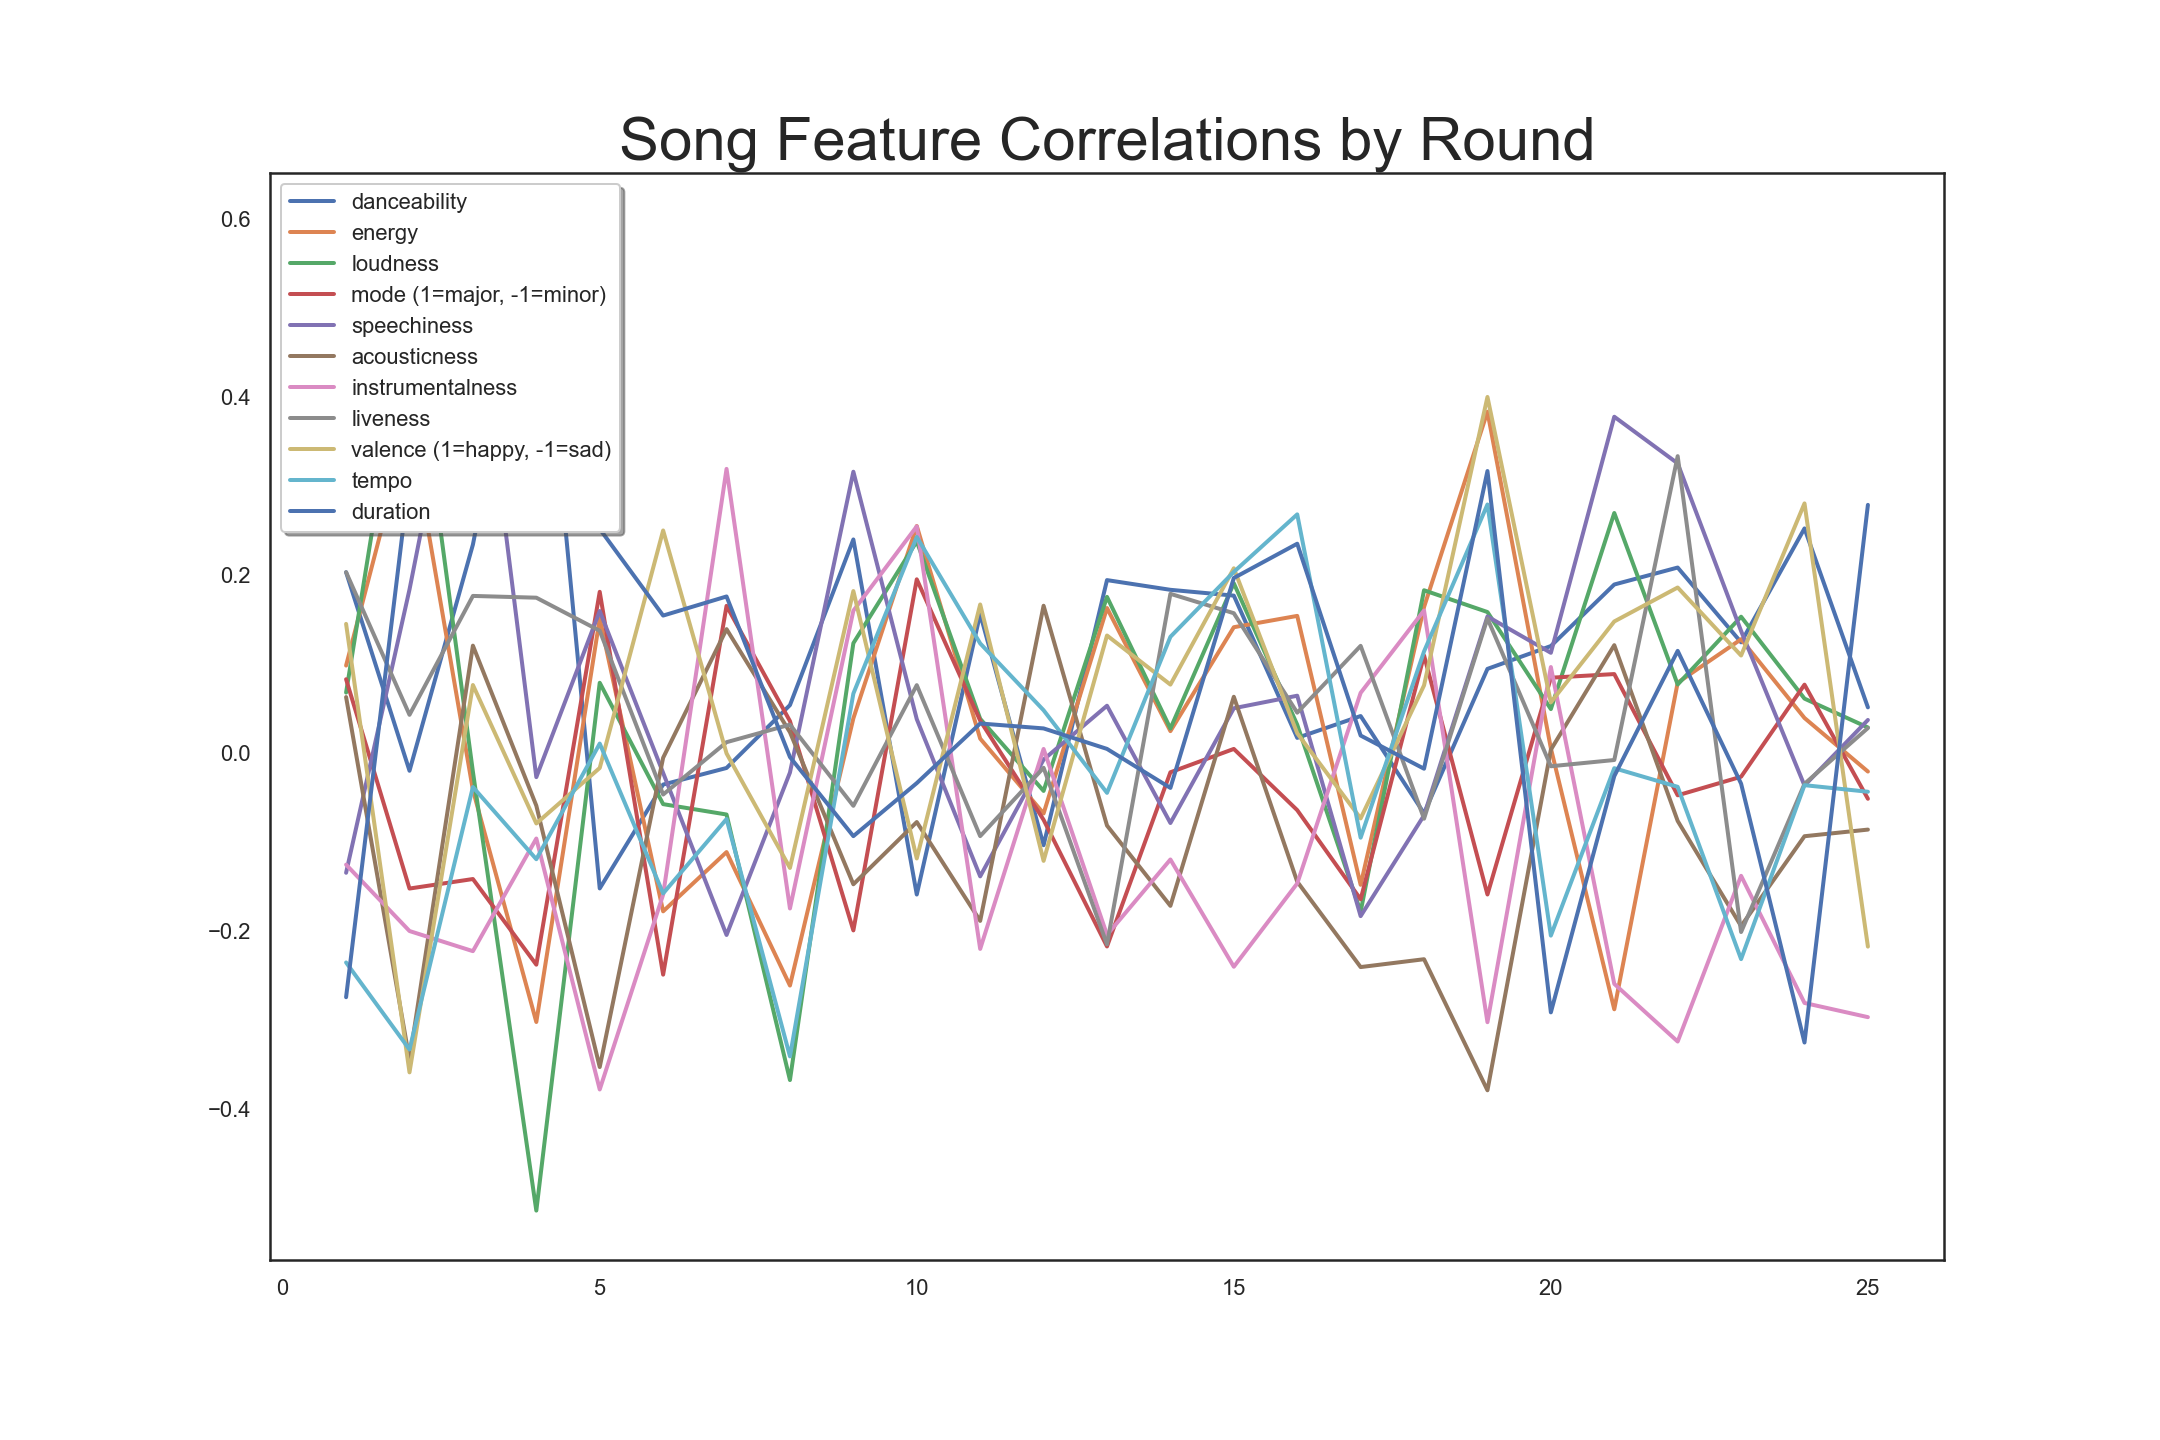

9

In [94]:
#graphing individual lines for each feature based on those arrays
%matplotlib notebook
fig, ax = plt.subplots()
ax.set_title('Song Feature Correlations by Round', size=60)
danceability_line, = ax.plot(t, danceability_corr_array, lw=2, label='danceability')
energy_line, = ax.plot(t, energy_corr_array, lw=2, label='energy')
loudness_line, = ax.plot(t, loudness_corr_array, lw=2, label='loudness')
mode_line, = ax.plot(t, mode_corr_array, lw=2, label='mode (1=major, -1=minor)')
speechiness_line, = ax.plot(t, speechiness_corr_array, lw=2, label='speechiness')
acousticness_line, = ax.plot(t, acousticness_corr_array, lw=2, label='acousticness')
instrumentalness_line, = ax.plot(t, instrumentalness_corr_array, lw=2, label='instrumentalness')
liveness_line, = ax.plot(t, liveness_corr_array, lw=2, label='liveness')
valence_line, = ax.plot(t, valence_corr_array, lw=2, label='valence (1=happy, -1=sad)')
tempo_line, = ax.plot(t, tempo_corr_array, lw=2, label='tempo')
duration_line, = ax.plot(t, duration_corr_array, lw=2, label='duration')

plt.legend(loc=2, prop={'size':20})

plt.title("Song Feature Correlations by Round", size=30)

leg = ax.legend(fancybox=True, shadow=True, loc=2)


#making the legend interactive
lines = [danceability_line, energy_line, loudness_line, mode_line, speechiness_line, acousticness_line,
        instrumentalness_line, liveness_line, valence_line, tempo_line, duration_line]
lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    lined[legline] = origline


def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

plt.gcf().set_size_inches(15, 10)
fig.canvas.mpl_connect('pick_event', on_pick)

## 3.1 Graphing personal correlations
### It turns out the above tells us absolutely nothing. Maybe personal-level feature stuff is interesting!

person_level_corr established earlier

In [34]:
person_level_corr = person_level_corr.reset_index()

In [35]:
del person_level_corr['level_1']

In [36]:
vote_and_submissions.head()

Spotify_URI                          Voter_ID  \
15607  spotify:track:5MMW4CZsZiZt2iuqAXzzWC  4db453a9dc464c61ac6cba5da3eeea43   
15754  spotify:track:7eArOOr6p5TiYNGH6jHALx  1ecb480139f24cc98c2ce6a2c2af9e4e   
15755  spotify:track:7fDPgekQGJKkyyqjuhtNSG  1ecb480139f24cc98c2ce6a2c2af9e4e   
15756  spotify:track:7it1zs6df7l7SKYa0dbkfQ  1ecb480139f24cc98c2ce6a2c2af9e4e   
15757  spotify:track:7qQMtg44hxQ0ga7NhyyNxR  1ecb480139f24cc98c2ce6a2c2af9e4e   

              Created_voter  Points_Assigned Comment_voter  \
15607  2022-09-10T23:21:02Z                2           NaN   
15754  2022-09-11T14:22:28Z                1           NaN   
15755  2022-09-11T14:22:28Z                1           NaN   
15756  2022-09-11T14:22:28Z                1           NaN   
15757  2022-09-11T14:22:28Z                1           NaN   

                               Round_ID                          ID_voter  \
15607  09502eae8e58411fbe1f640e2d5d837b  4db453a9dc464c61ac6cba5da3eeea43   
15754  09502eae8e58411fbe1f640e2d5d837b  1ecb480139f24cc98c2ce6a2c2af9e4e   
15755  09502eae8e58411fbe1f640e2d5d837b  1ecb480139f24cc98c2ce6a2c2af9e4e   
15756  09502eae8e58411fbe1f640e2d5d837b  1ecb480139f24cc98c2ce6a2c2af9e4e   
15757  09502eae8e58411fbe1f640e2d5d837b  1ecb480139f24cc98c2ce6a2c2af9e4e   

      Name_voter                      Submitter_ID     Created_submitter  \
15607       Nate  72d29831b3ff49b08781d8d8d7770e8a  2022-09-04T23:06:13Z   
15754    melissa  95367467c3c244779c24ee4e208d4951  2022-09-05T03:15:12Z   
15755    melissa  785c8c32eeeb4d73ac591923d6be0ab3  2022-09-04T23:09:15Z   
15756    melissa  23aa3e4f1f204e0ea5e8862ac5dde426  2022-09-04T23:14:56Z   
15757    melissa  f99a5821c49d4a8eaa40dbc457beda3c  2022-09-05T01:02:26Z   

                                       Comment_submitter  \
15607                                                NaN   
15754  This came out in January, and I posted it in t...   
15755                                                NaN   
15756  T4T Jesus and Judas having period sex? What's ...   
15757  I will always go fucking nuts to hear this man...   

                           ID_submitter     Name_submitter  
15607  72d29831b3ff49b08781d8d8d7770e8a          Jonathan   
15754  95367467c3c244779c24ee4e208d4951             Oliver  
15755  785c8c32eeeb4d73ac591923d6be0ab3  Mr. Peanut Butter  
15756  23aa3e4f1f204e0ea5e8862ac5dde426             Sidney  
15757  f99a5821c49d4a8eaa40dbc457beda3c       Jack Fleming

In [37]:
mean_correlations = pd.merge(vote_and_submissions[['Spotify_URI','Name_voter','Points_Assigned']],song_feature_analysis,on='Spotify_URI')
del mean_correlations['Points_Assigned_y']
del mean_correlations['mode']
del mean_correlations['key']
del mean_correlations['time_signature']
del mean_correlations['Spotify_URI']
del mean_correlations['Name_voter']
del mean_correlations['Round_ID']
mean_correlations = mean_correlations.corr()

### Note for me - I think I shuold convert the "find personal features" bit into another function since i'll use that to predict the songs you'll like later

In [38]:
%matplotlib inline

In [39]:
def print_radargraph(name):
    #first, get the subset to reference
    all_matches = person_level_corr[person_level_corr['Name_voter'].str.contains(name)]
    testradar = all_matches.iloc[0,2:12]
    meanradar = mean_correlations.iloc[0,1:]
    
    #then, set up the chart
    categories = ['danceability','energy','loudness',
                  'speechiness', 'acousticness',
                  'instrumentalness', 'liveness',
                  'valence','tempo','duration']
    categories2 = [*categories, categories[0]]

    personal_features = testradar
    personal_features = [*personal_features, personal_features[0]]

    mean_features = meanradar
    mean_features = [*mean_features, mean_features[0]]
    
    #get to graphing!
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=mean_features, theta=categories2, fill='toself', name='Group Correlations'),
            go.Scatterpolar(r=personal_features, theta=categories2, fill='toself', name='Your Correlations'),

        ],
        layout=go.Layout(
            title=go.layout.Title(text='Personal Feature Chart'),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
            )
    )
    fig.update_polars(radialaxis=dict(range=[-.15, .15]))
    fig.show()

# 4. You can use this to find your personal feature correlations
### Just put in a part of your name that doesn't include spaces, exactly as it appears on music league.
#### No spaces! 
#### Caps-sensitive!
#### I'll include a full list.

In [40]:
competitors['Name']

0          Jack Fleming
1        Quinn (He/Him)
2                 y2ckt
3               hammond
4         Fondueprocess
5               Heather
6                Oliver
7               Allison
8                Will D
9                 scott
10          Aidanread27
11            Brendon Y
12    Mr. Peanut Butter
13          chayamichla
14                   JR
15         Gideon Jones
16               em.………
17       Erin (she/her)
18                 IAAP
19               Zach V
20                 Zach
21               Sandra
22            Jonathan 
23                Ethan
24                  Dan
25                 meg 
26             nr031197
27              melissa
28      tyler (she/her)
29                Joe E
30            Klayton A
31          Gooth Ghoul
32           Lemon Bowl
33        joshuahwatson
34                Rob K
35              joshb42
36                 Dana
37                 Nate
38                 seth
39                Jared
40                Dylan
41              

In [92]:
myname = 'Jack'

In [93]:
print_radargraph(myname)

# 5. Heatmaps for Voting Habits
## Here, I pull together the data for heatmapping on voting habits. 

In [43]:
points_for = points_for.reset_index()

In [44]:
#clean up votes_for and votes_cast before merging into votes_for
votes_cast.rename(columns={'Points_Assigned': 'total_points_cast'}, inplace=True)
votes_cast = votes_cast.reset_index()
votes_for = votes_for.reset_index()

votes_for.rename(columns={'Points_Assigned': 'num_times_voted'}, inplace=True)

In [45]:
#reducing the votes_for and points_for tables into voter,submitter, and the relevant counts
del votes_for['Spotify_URI']
del votes_for['Created_voter']
del votes_for['Comment_voter']
del votes_for['Round_ID']
del votes_for['Created_submitter']
del votes_for['Comment_submitter']
del votes_for['ID_voter']
del votes_for['ID_submitter']
del votes_for['Voter_ID']
del votes_for['Submitter_ID']

votes_for.head()

Name_voter Name_submitter  num_times_voted
0  Aidanread27        Allison               16
1  Aidanread27         Angela               10
2  Aidanread27      Brendon Y               12
3  Aidanread27           Carl               12
4  Aidanread27            Dan               12

In [46]:
#combine the votes_cast table with points_for
points_for = points_for.merge(votes_cast, how='left', on=['Name_voter'])

In [47]:
avg_vote = votes_for.merge(points_for[['Name_voter', 'Name_submitter', 'Points_Assigned']], how='left', on=['Name_voter', 'Name_submitter'])
avg_vote["per_instance_avg"]=(avg_vote["Points_Assigned"]/avg_vote["num_times_voted"])
avg_vote = avg_vote.round({'per_instance_avg': 1})

In [48]:
#sns.scatterplot(x=points_for['Name_voter'],y=points_for['Name_submitter'],size=points_for['Points_Assigned'], sizes=(0,2500))
#plt.gcf().set_size_inches(32, 32)

In [49]:
#once they're merged, figure out what vote share goes to each other person
points_for["percent_share"]=(points_for["Points_Assigned"]/points_for["total_points_cast"])*100
percent_votes=points_for

In [50]:
#replace NaN with 0
percent_votes.fillna(0)
votes_for.fillna(0)
points_for.fillna(0)
avg_vote.fillna(0)

Name_voter   Name_submitter  num_times_voted  Points_Assigned  \
0     Aidanread27          Allison               16               36   
1     Aidanread27           Angela               10               22   
2     Aidanread27        Brendon Y               12               25   
3     Aidanread27             Carl               12               23   
4     Aidanread27              Dan               12               27   
...           ...              ...              ...              ...   
2170        y2ckt             owat                2                4   
2171        y2ckt            scott               12               16   
2172        y2ckt             sean               11               20   
2173        y2ckt             seth                3                3   
2174        y2ckt  tyler (she/her)               10               12   

      per_instance_avg  
0                  2.2  
1                  2.2  
2                  2.1  
3                  1.9  
4                  2.2  
...                ...  
2170               2.0  
2171               1.3  
2172               1.8  
2173               1.0  
2174               1.2  

[2175 rows x 5 columns]

In [51]:
#doing the pivot tables
percent_votes_t = percent_votes.pivot(index='Name_voter', columns='Name_submitter', values='percent_share')
votes_for_t = votes_for.pivot(index='Name_voter', columns='Name_submitter', values='num_times_voted')
points_for_t = points_for.pivot(index='Name_voter', columns='Name_submitter', values='Points_Assigned')
avg_vote_t = avg_vote.pivot(index='Name_voter', columns='Name_submitter', values='per_instance_avg') 

In [52]:
#replace NaN with 0
percent_votes_t = percent_votes_t.fillna(0)
votes_for_t = votes_for_t.fillna(0)
points_for_t = points_for_t.fillna(0)
avg_vote_t = avg_vote_t.fillna(0)

In [53]:
%matplotlib inline

In [54]:
def print_heatmap(df, title):
    %matplotlib inline
    ax = sns.heatmap(df,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
    sns.set_theme(style="white")
    plt.title(title)
    plt.gcf().set_size_inches(32, 32)

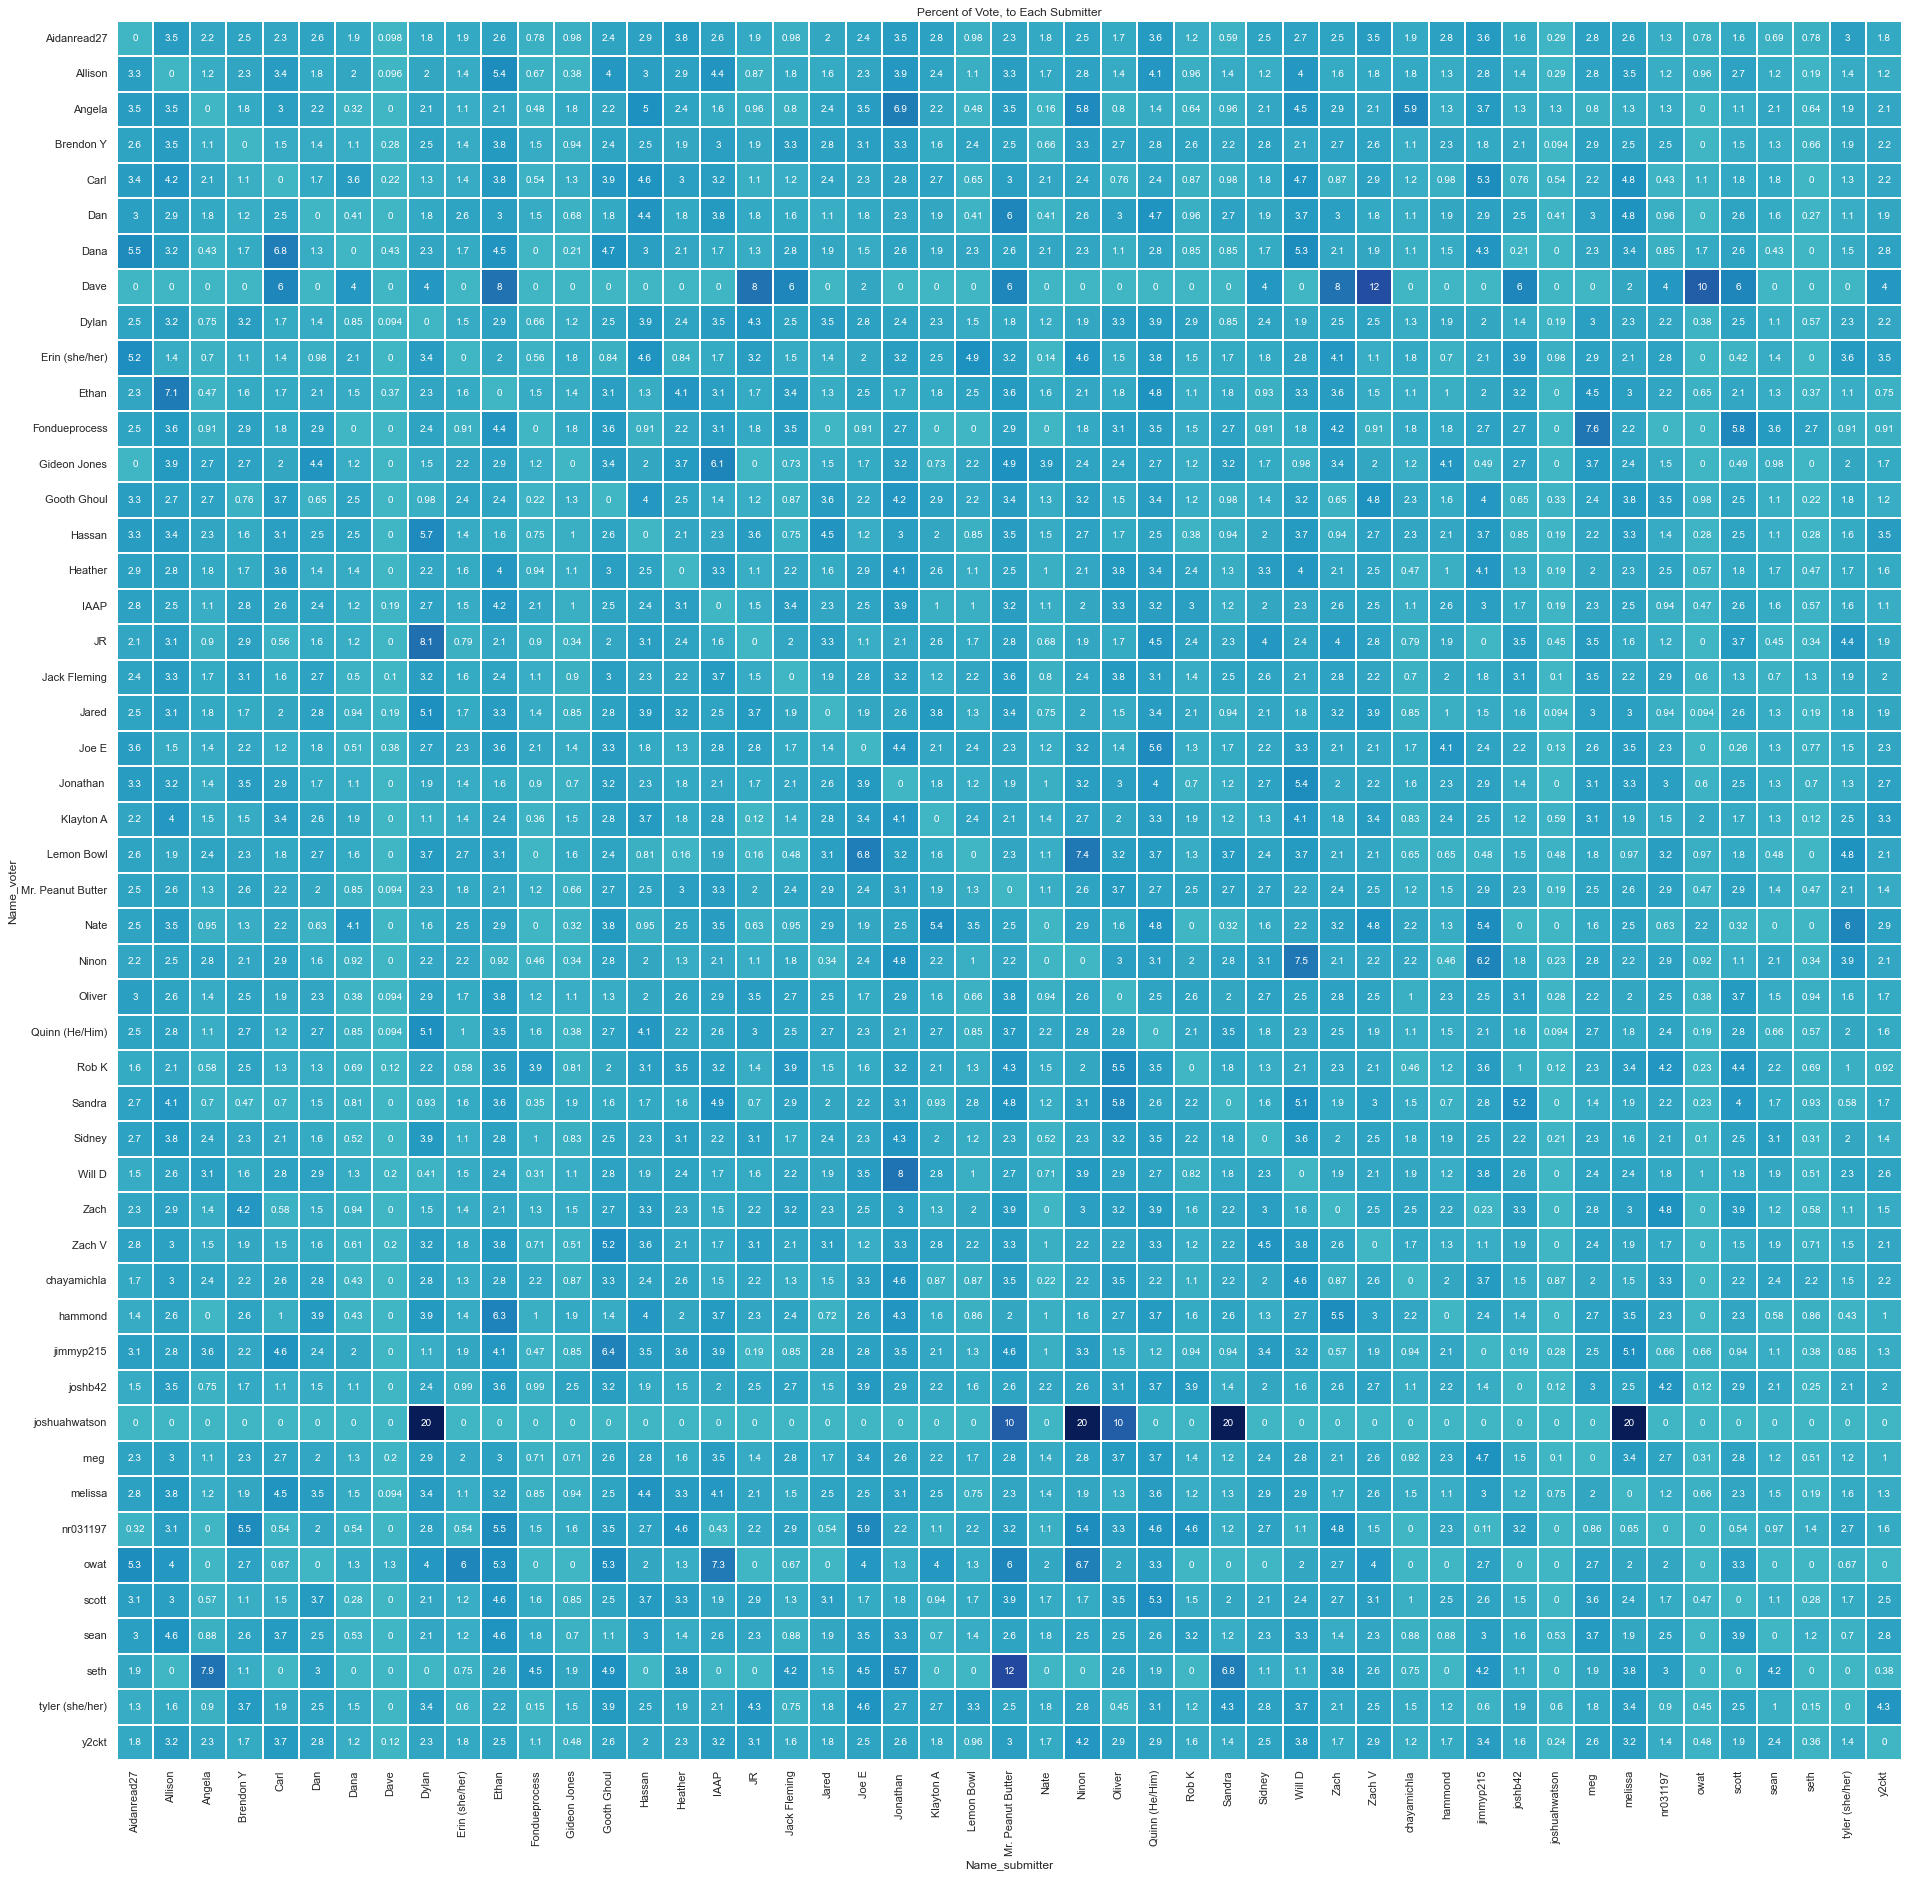

In [55]:
print_heatmap(percent_votes_t, "Percent of Vote, to Each Submitter")

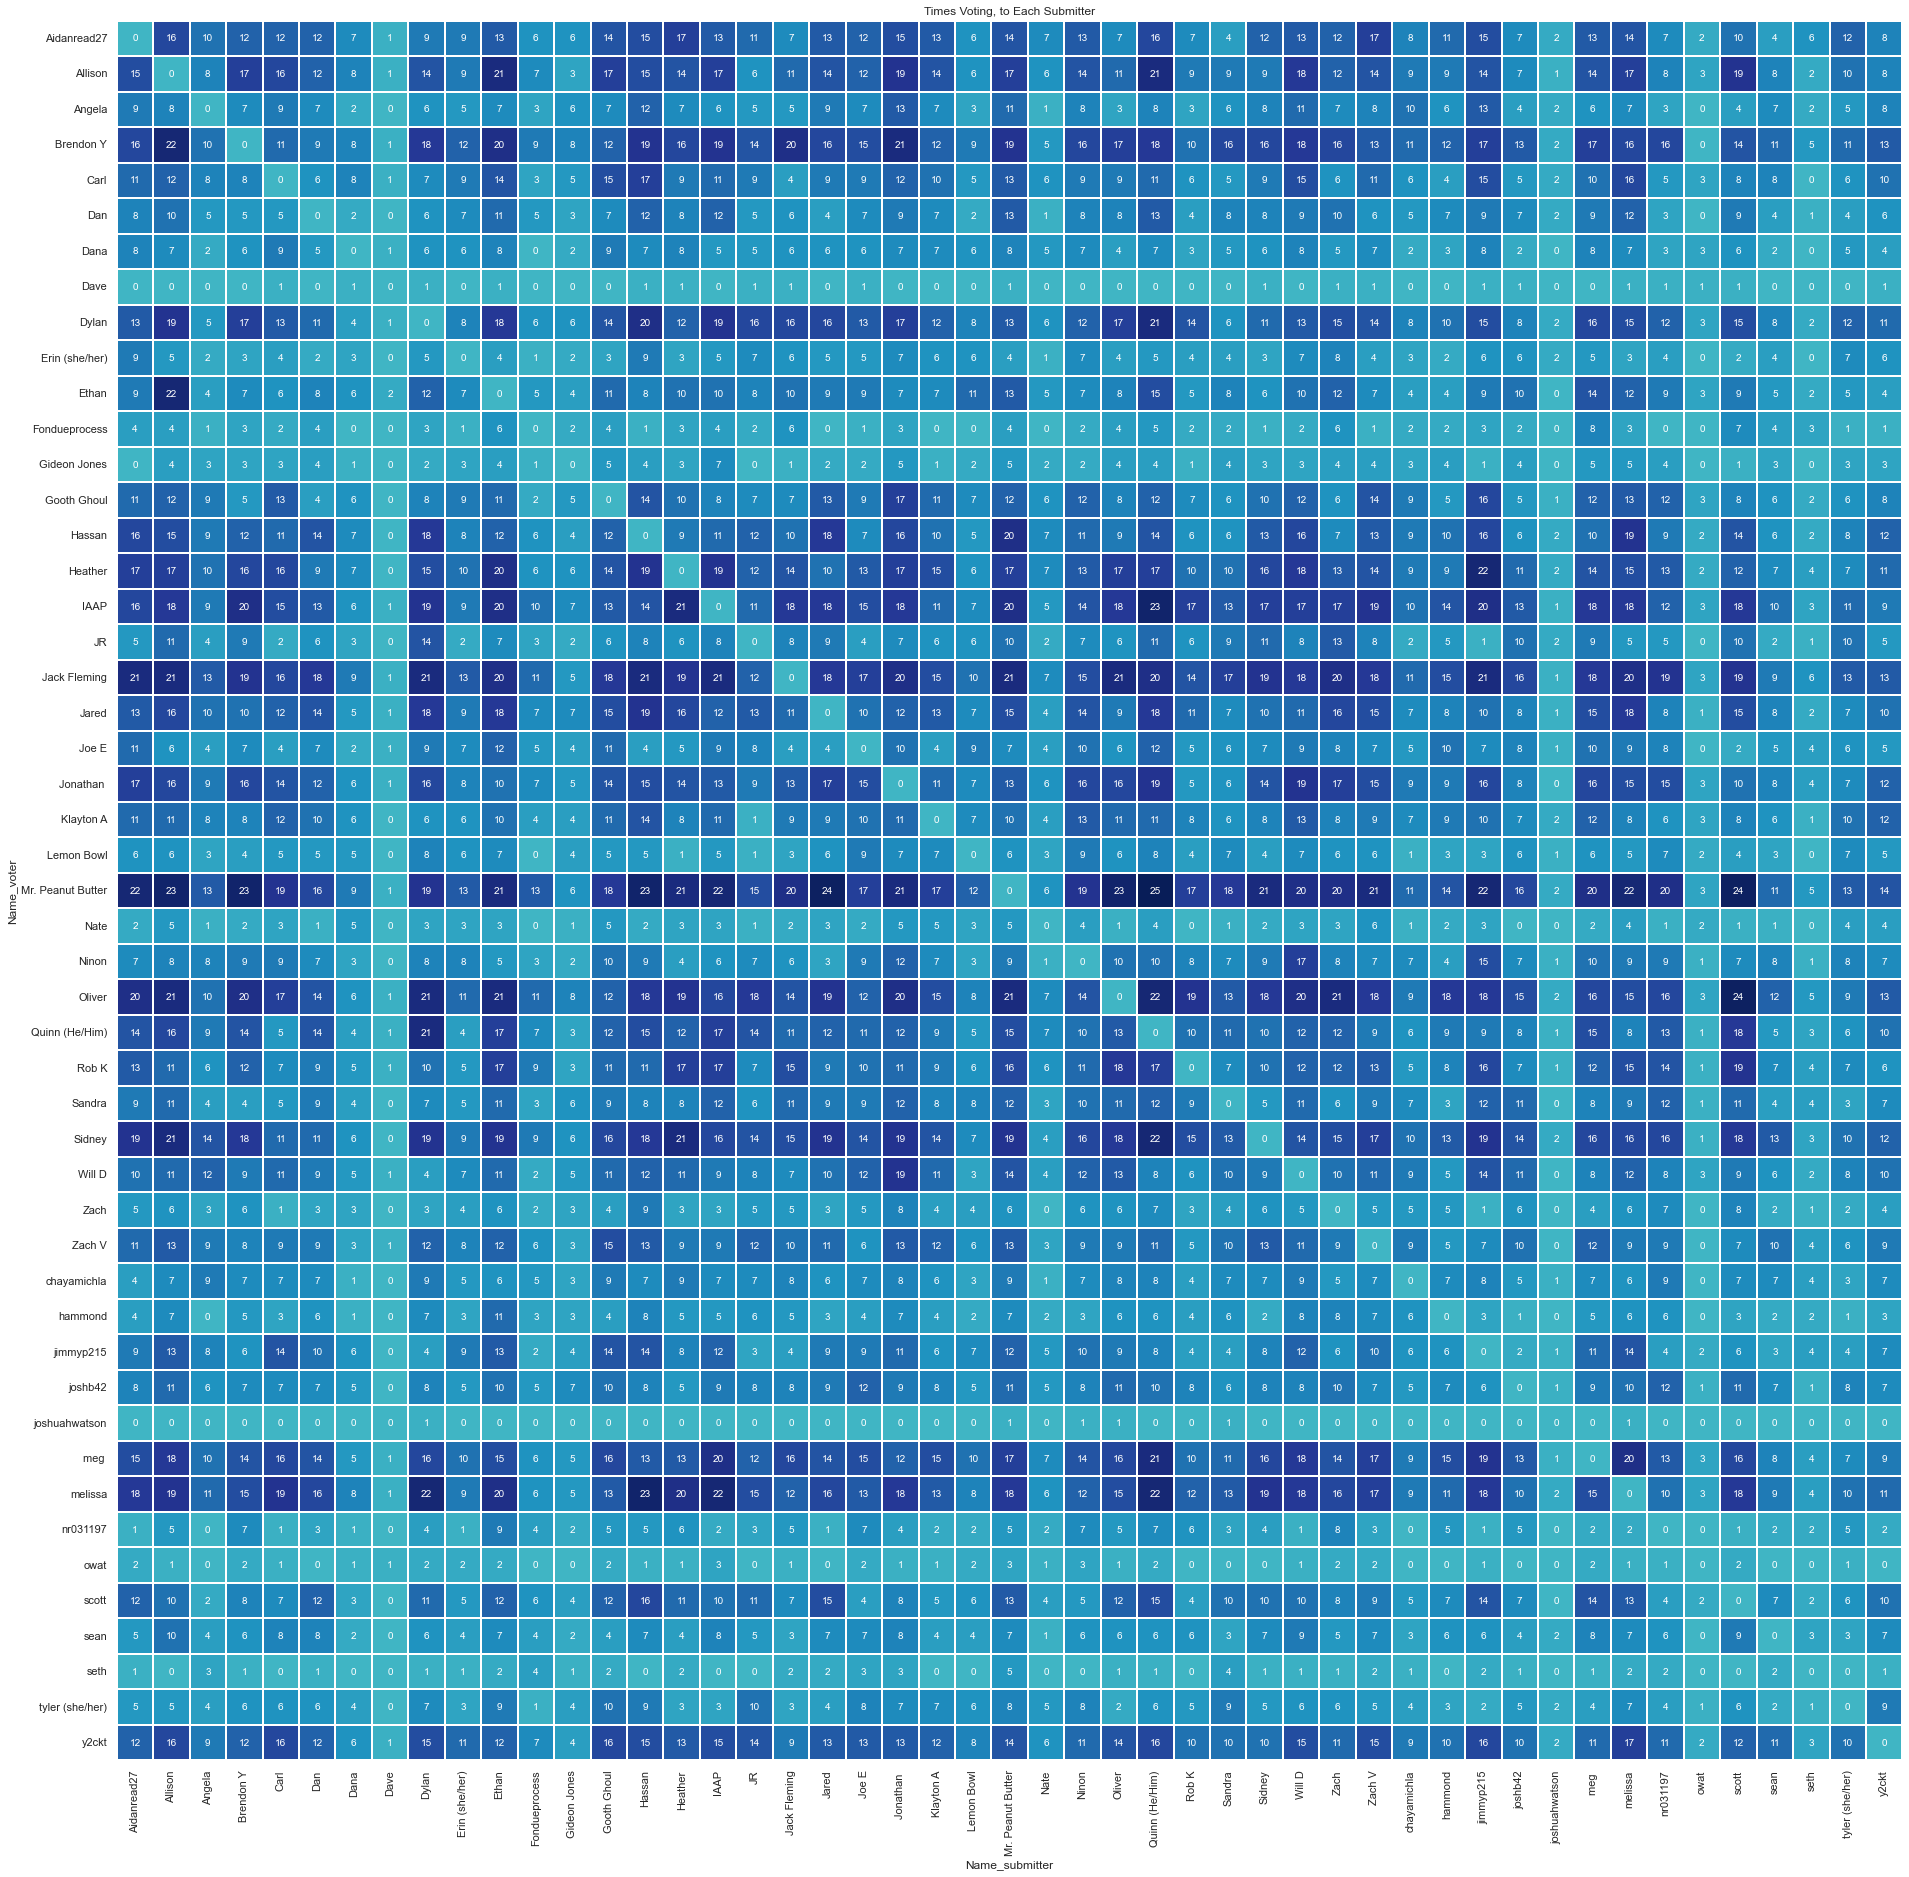

In [56]:
print_heatmap(votes_for_t, "Times Voting, to Each Submitter")

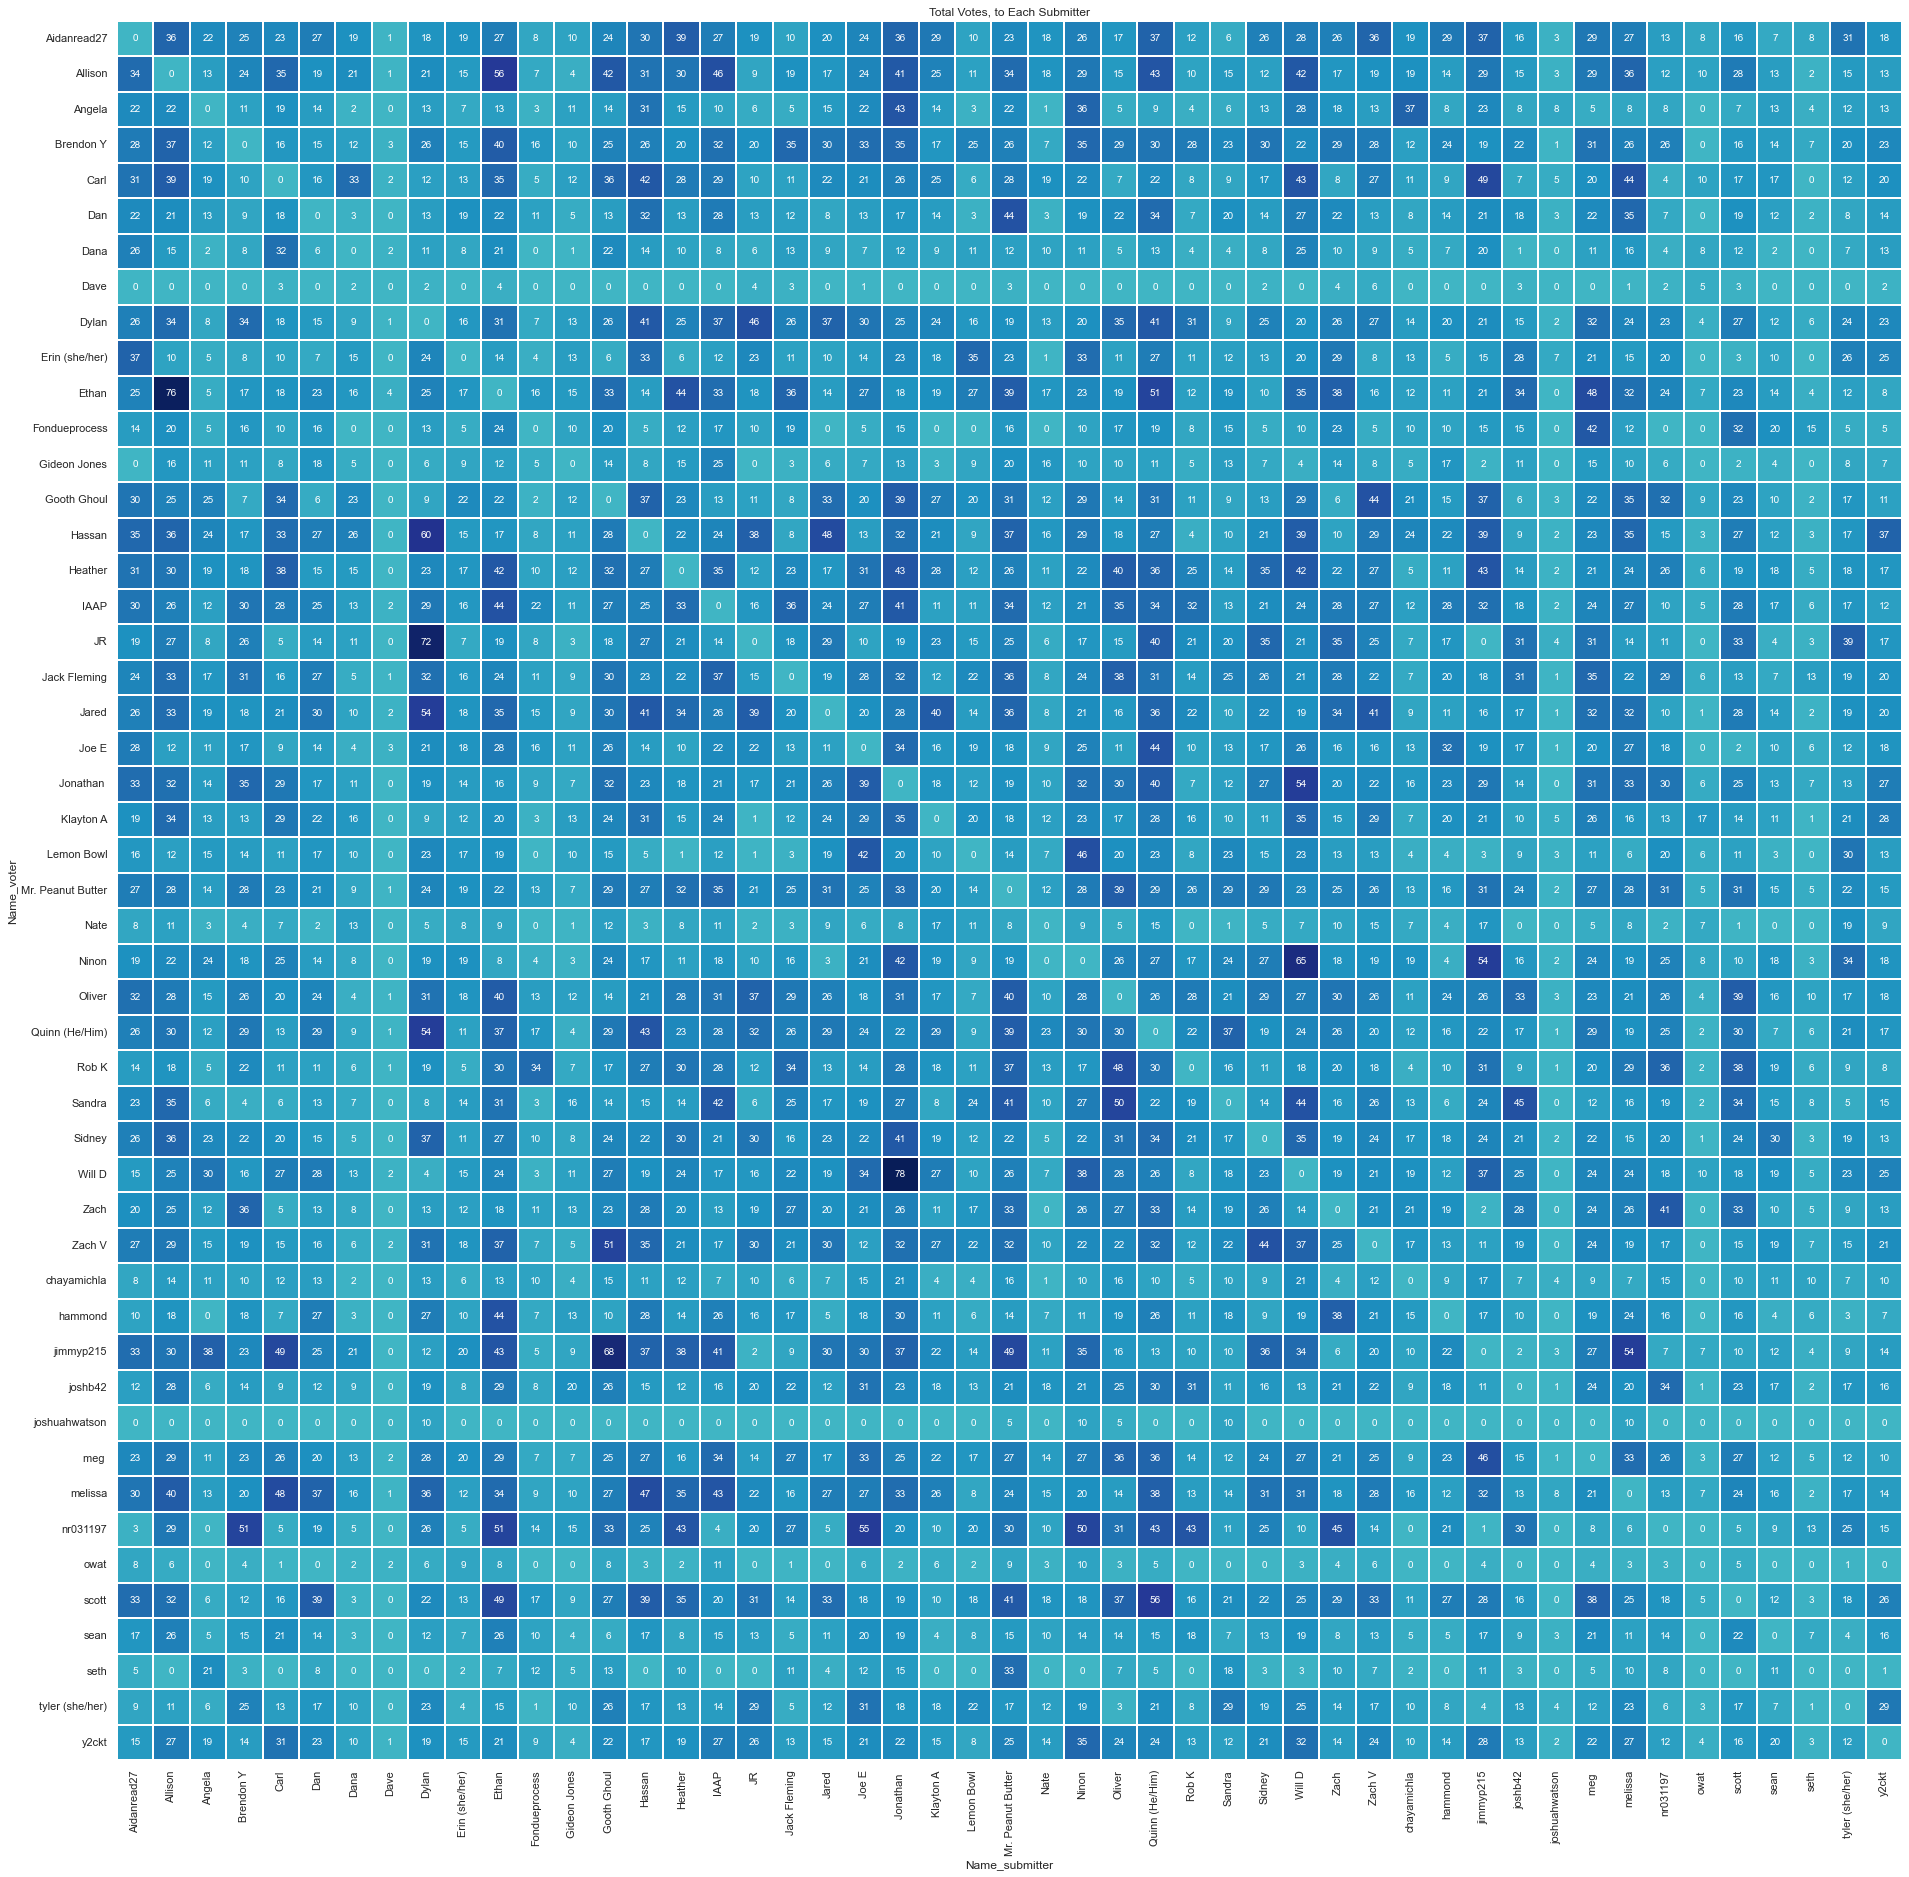

In [57]:
print_heatmap(points_for_t, "Total Votes, to Each Submitter")

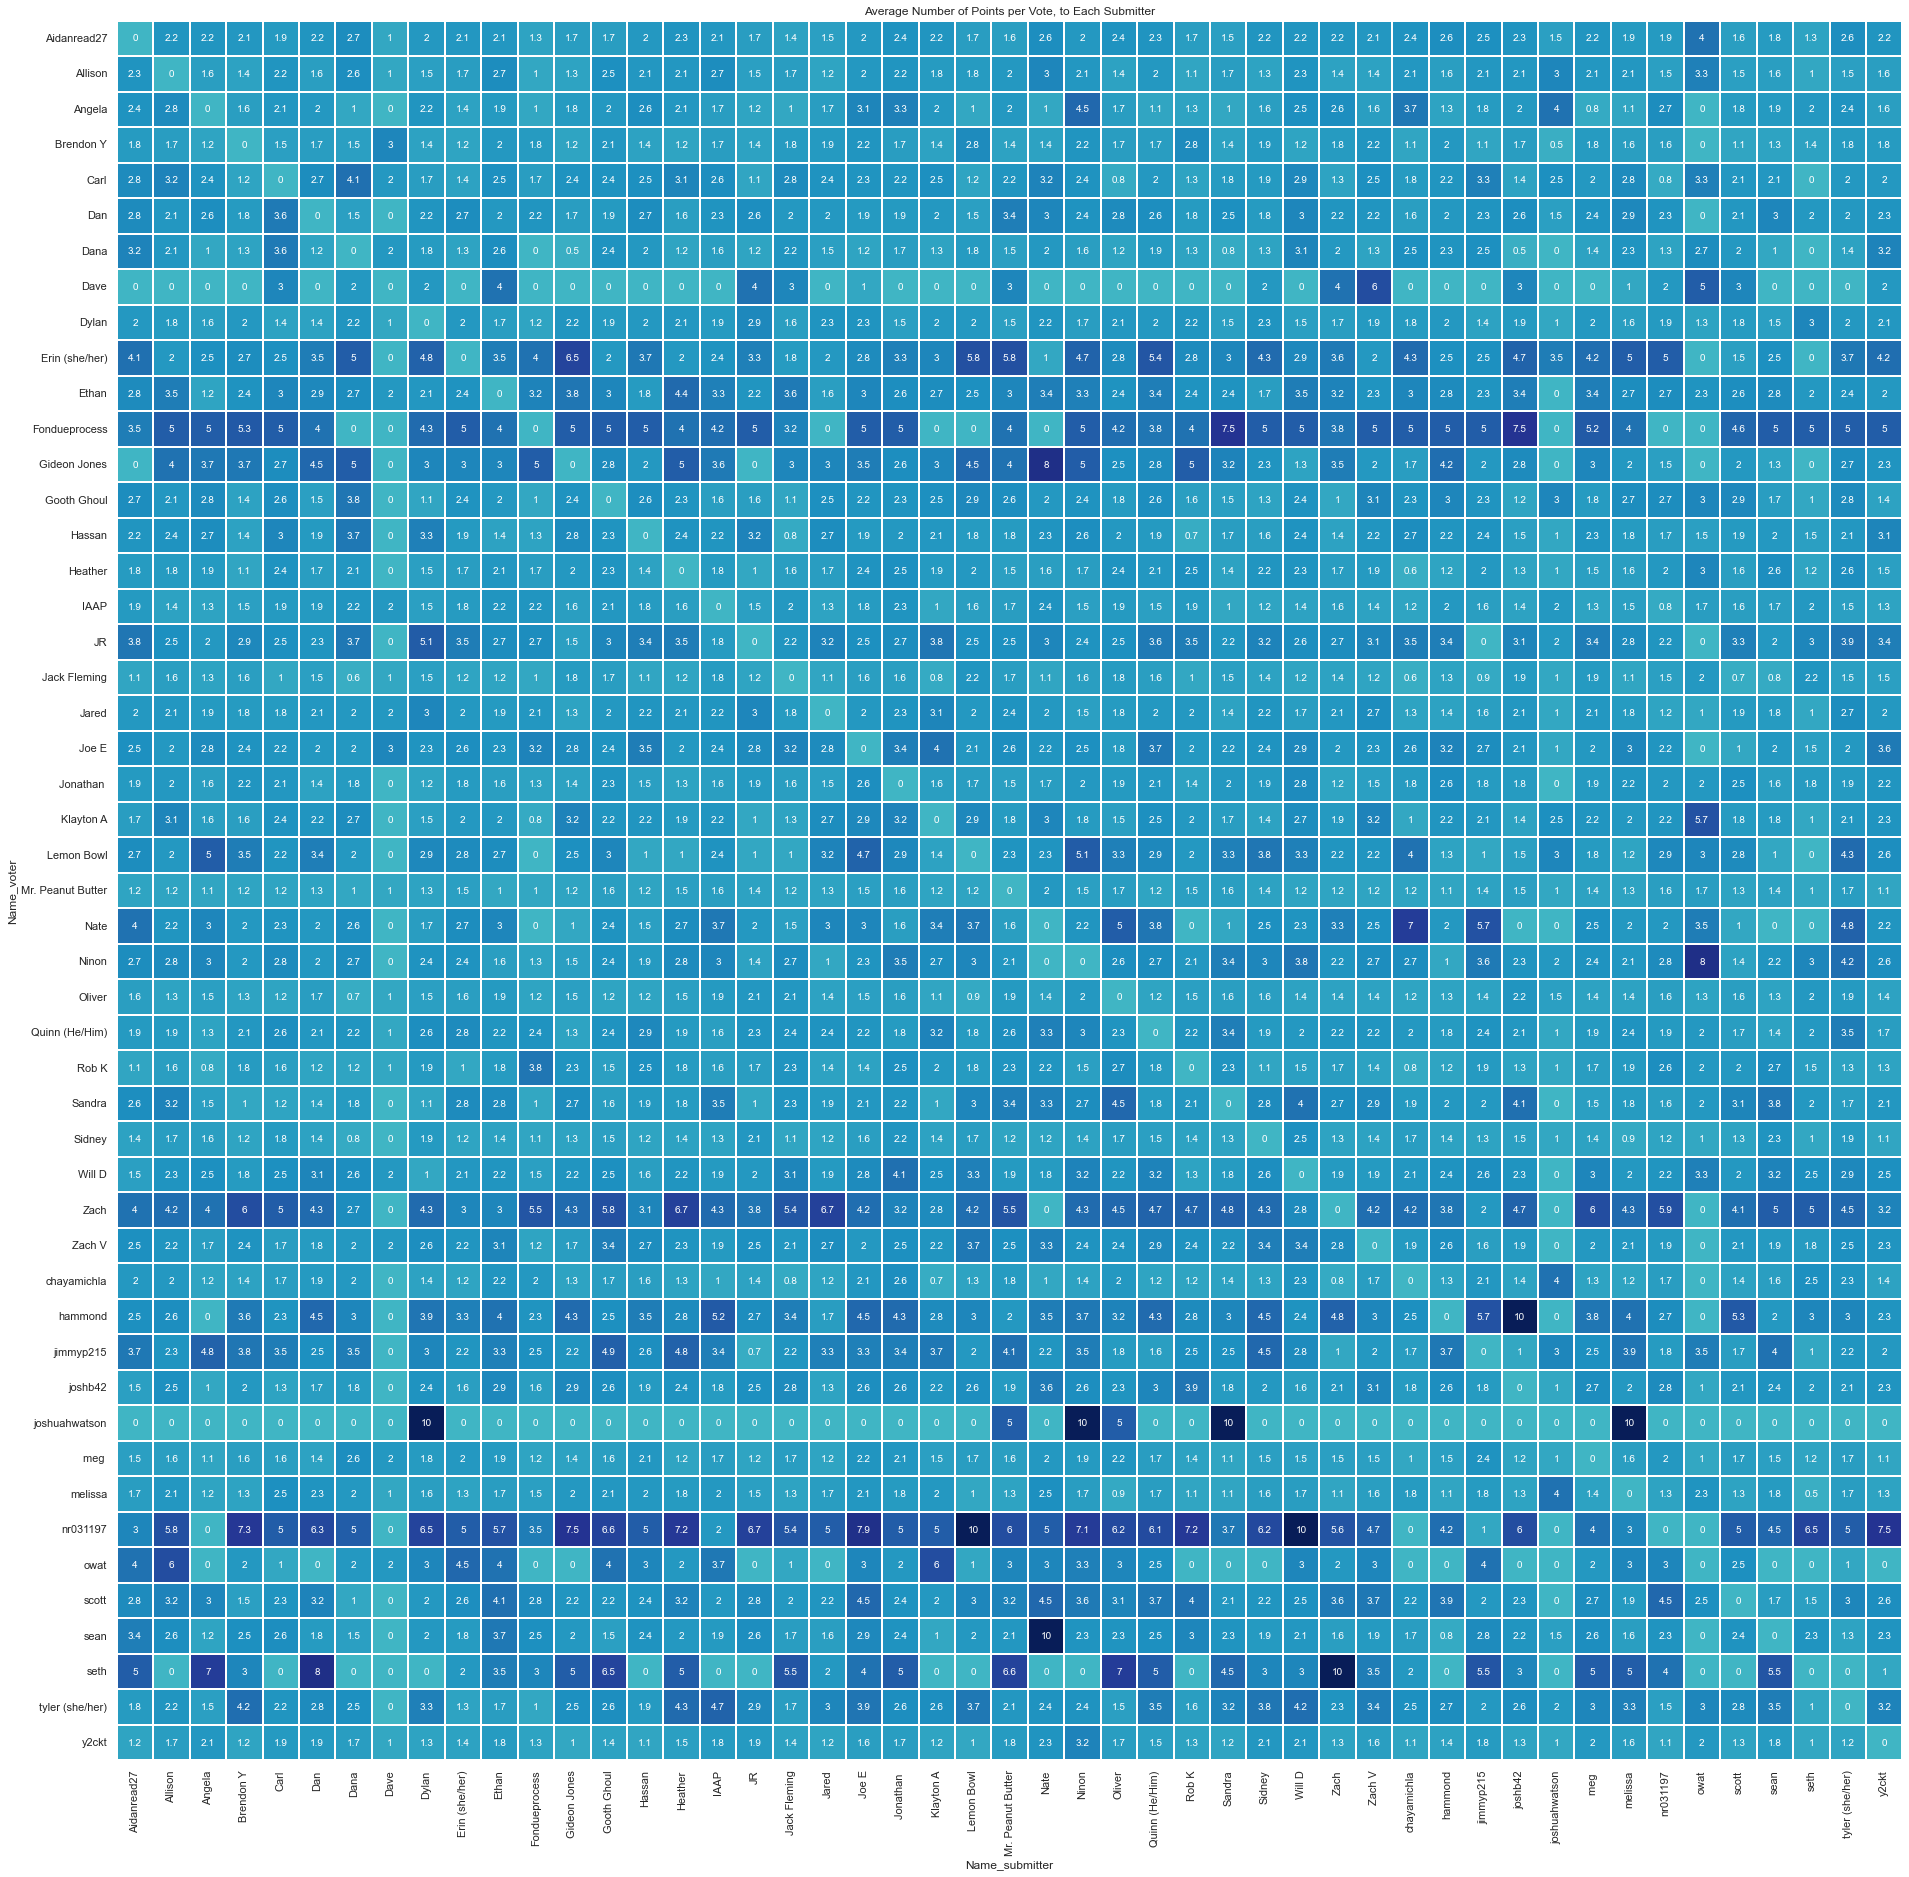

In [58]:
print_heatmap(avg_vote_t, "Average Number of Points per Vote, to Each Submitter")

In [59]:
#here, I create points_for_array and tranpose points_for_t so that the columns represent who the voter voted for
#that way, I can compare using .corr() from one column to the next 
points_for_array = points_for_t.transpose()
correlation_scores = points_for_array.corr()
correlation_scores = correlation_scores.round(2)
correlation_scores = correlation_scores.fillna(0)
correlation_scores.head()

Name_voter   Aidanread27  Allison  Angela  Brendon Y  Carl   Dan  Dana  Dave  \
Name_voter                                                                     
Aidanread27         1.00     0.51    0.45       0.43  0.57  0.44  0.36  0.01   
Allison             0.51     1.00    0.43       0.44  0.61  0.63  0.68  0.04   
Angela              0.45     0.43    1.00       0.38  0.44  0.37  0.43 -0.13   
Brendon Y           0.43     0.44    0.38       1.00  0.38  0.55  0.39  0.11   
Carl                0.57     0.61    0.44       0.38  1.00  0.54  0.52 -0.09   

Name_voter   Dylan  Erin (she/her)  ...  joshuahwatson  meg   melissa  \
Name_voter                          ...                                 
Aidanread27   0.53            0.16  ...          -0.05  0.54     0.61   
Allison       0.41            0.29  ...           0.11  0.59     0.60   
Angela        0.25            0.44  ...           0.09  0.39     0.53   
Brendon Y     0.60            0.50  ...           0.21  0.58     0.46   
Carl          0.37            0.21  ...           0.06  0.53     0.49   

Name_voter   nr031197  owat  scott  sean  seth  tyler (she/her)  y2ckt  
Name_voter                                                              
Aidanread27      0.36  0.32   0.54  0.43  0.09             0.30   0.64  
Allison          0.23  0.58   0.49  0.48  0.23             0.40   0.60  
Angela           0.21  0.28   0.26  0.39  0.13             0.28   0.45  
Brendon Y        0.45  0.42   0.64  0.58  0.21             0.32   0.54  
Carl             0.05  0.47   0.44  0.39  0.20             0.30   0.53  

[5 rows x 49 columns]

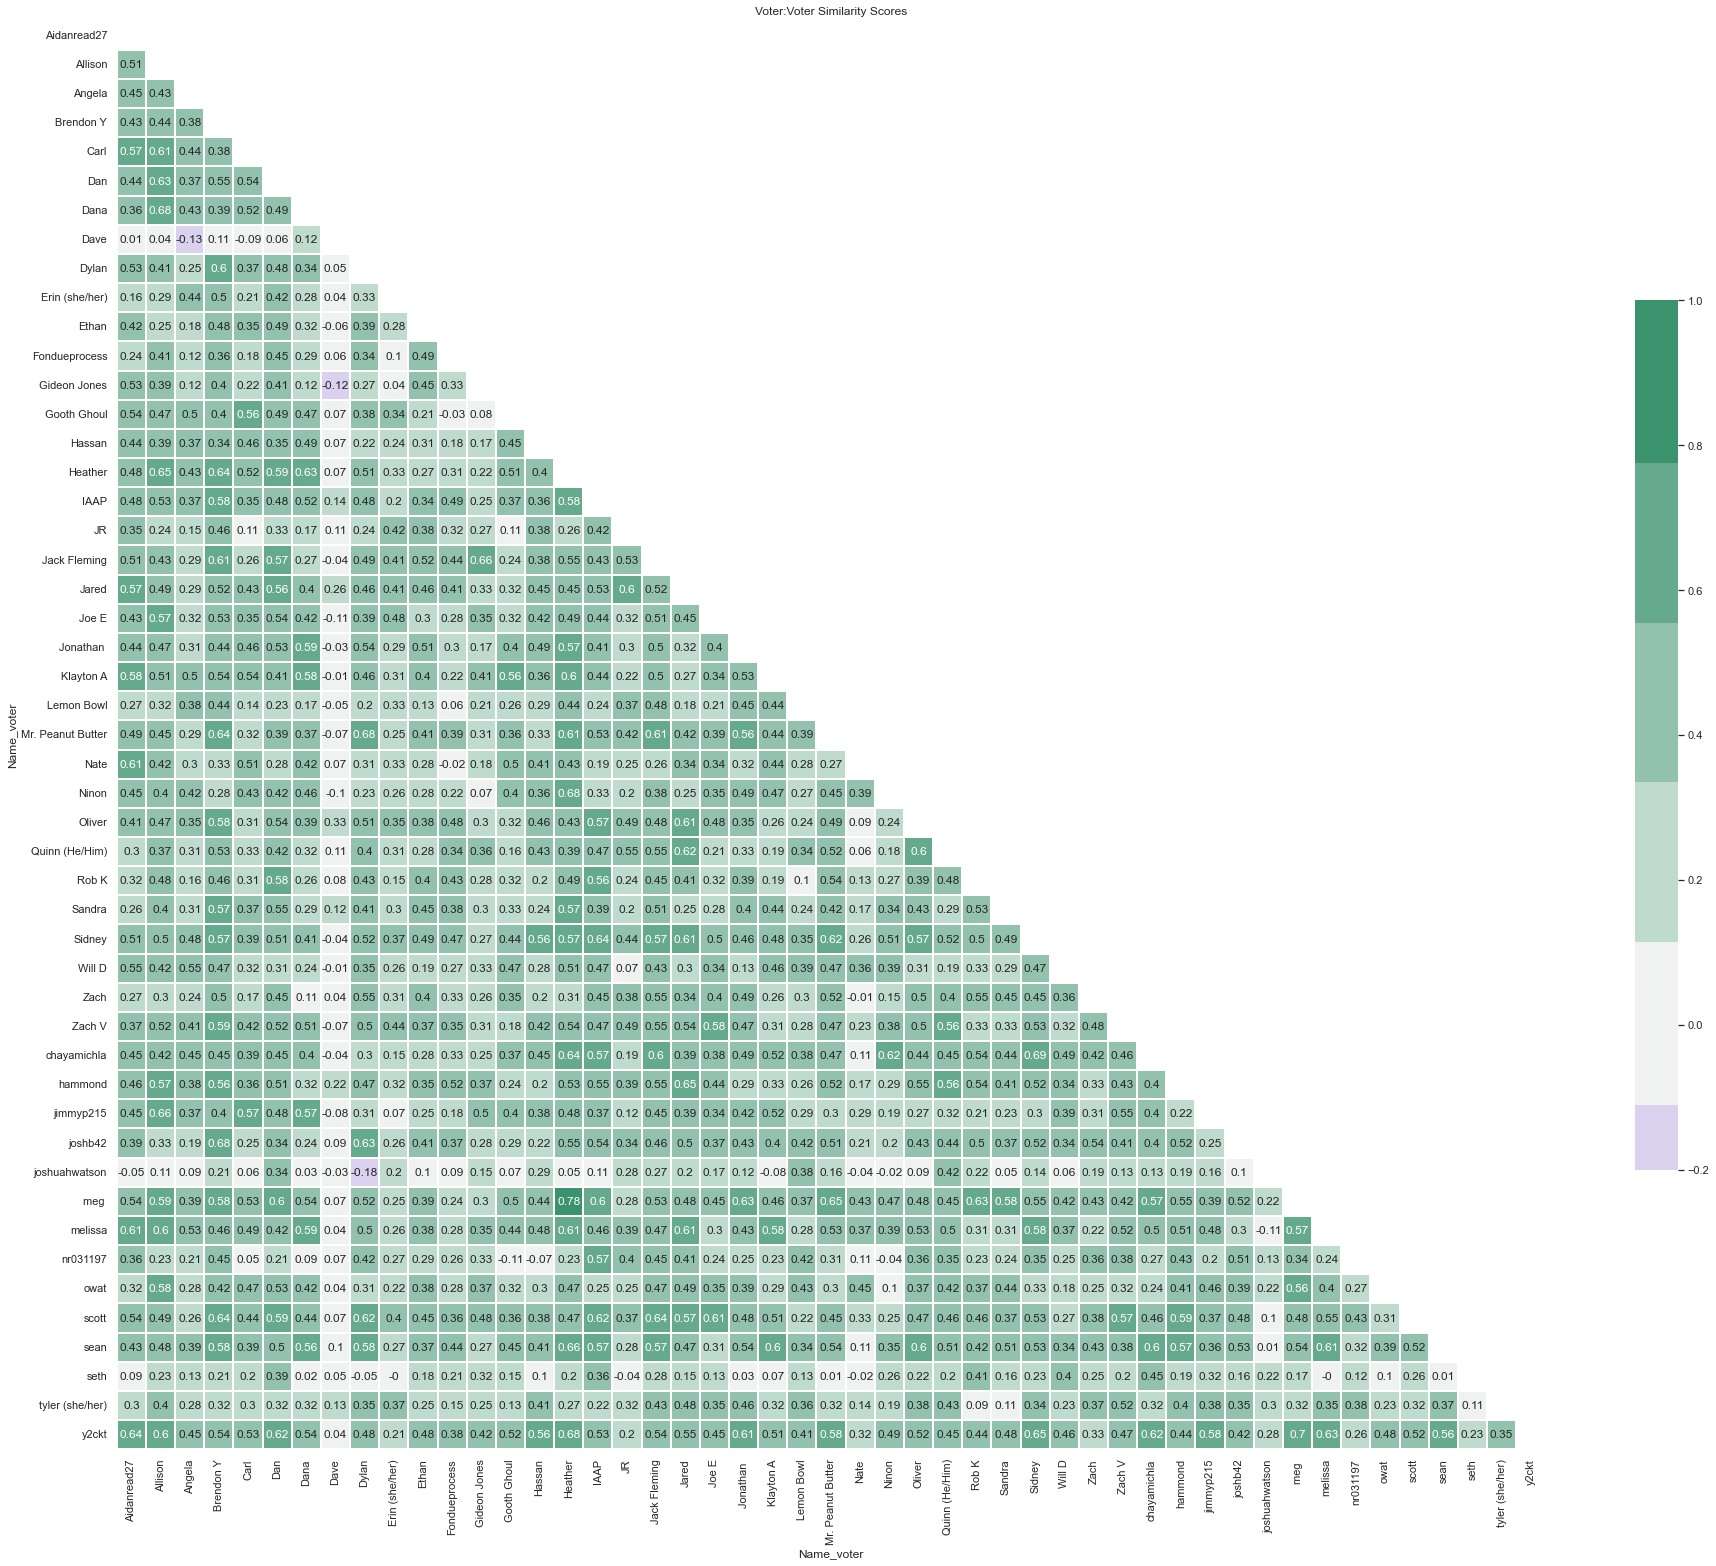

In [60]:
#heatmap for similarity in voting
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_scores, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(275, 150, s=80, l=55, n=9)


#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_scores, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-.2,
            square=True, linewidths=.25, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True, annot=True)

plt.title('Voter:Voter Similarity Scores')
plt.gcf().set_size_inches(32, 32)

In [61]:
#trying out cluster mapping
#sns.clustermap(correlation_scores,xticklabels=True, yticklabels=True, annot=True, linewidths=.25, center=0, cmap="YlGnBu", cbar=False)
#plt.title('clustermap')
#plt.gcf().set_size_inches(32, 32)

In [62]:
# % of your votes that went to the bottom 3 of each round
# % of your votes that went to the top 3 of each round
# to start out, need to figure out what's the order of songs in each round

round_song_sum = vote_and_submissions.groupby(['Round_ID', 'Name_submitter']).sum('Points_Assigned')
round_song_sum.rename(columns={'Points_Assigned': 'Points_Received'}, inplace=True)
e = round_song_sum.groupby('Round_ID').size()
num_per_round = pd.DataFrame(e)
num_per_round.rename(columns={0: 'count_songs'}, inplace=True)

# 6. Understanding Comments vs. Votes

In [63]:
#make a new df to capture competitor names, which we'll use to put round submission totals in
a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    num_per_round[new_col]="0"
    num_per_round[new_col] = pd.to_numeric(num_per_round[new_col])

In [64]:
num_per_round = num_per_round.reset_index()

In [65]:
#here I might not need x?

a = 0
b = 0
c = 0
x=0
y=0

#apply this to each round in the round spreadsheet
for a in range (0,len(num_per_round)):
    
    current_round_ID = num_per_round.at[a,'Round_ID']
    
    #while focusing in on a round, check each participant
    for b in range (2,len(num_per_round.columns)):
        
        current_competitor_name = num_per_round.columns[b]

        #with those two variables, run through every row of the vote_and_submissions df
        for c in range (0,len(vote_and_submissions)):
       
            #maybe something here with like a while x < 1 that increments once it happens once
        
            #first, see if the row in v_a_s's round matches the current one
            if vote_and_submissions.at[c,'Round_ID'] == current_round_ID:
                
                #if so, check to see if the participant name is the same. if y add a point
                if vote_and_submissions.at[c,'Name_voter'] == current_competitor_name:
                
                    num_per_round.iat[a,b]+=1
                    
            else:

                y+=1


## 6.1 Looking at total songs each competitor saw 

In [66]:


competitor_total_engagements = pd.DataFrame()
competitor_total_engagements.loc(0)
#'Songs_voted_on', 'Num_rounds_in'

a=0
iter = len(competitors)
for a in range (a, iter):

    new_col = competitors.at[a,'Name']
    competitor_total_engagements[new_col]= ""
    competitor_total_engagements.at[0,new_col]= 0
    competitor_total_engagements[new_col] = pd.to_numeric(competitor_total_engagements[new_col])

In [67]:
#here i'll see the number of songs that each competitor interacted with. 

a = 0
b = 0
c = 0
x = 0
y = 0

#apply this to each round in the round spreadsheet
for a in range (2,len(num_per_round.columns)):
    
    round_competitor = num_per_round.columns[a]
    
    #while focusing in on a round, check each participant
    for b in range (0,len(competitor_total_engagements.columns)):

        check_competitor = competitor_total_engagements.columns[b]
        
        #if the two columns match...
        if round_competitor == check_competitor:

            #run a for loop within the num_per_round sheet to get all the rows where their engagement !=0
            for c in range (0,len(num_per_round)):
                                
                    if num_per_round.iat[c,a] > 0:
                        
                        #assign a variable to the number in the round's total cells
                        x = num_per_round.iat[c,1]
                        
                        #add that to a variable for this person's total engaged
                        competitor_total_engagements.iat[0,b] = competitor_total_engagements.iat[0,b]+x

In [68]:
competitor_total_engagements.head()

Jack Fleming  Quinn (He/Him)  y2ckt  hammond  Fondueprocess  Heather  \
0           844             894    688      601            499      894   

   Oliver  Allison  Will D  scott  ...  Dylan  Hassan  sean  Carl  Angela  \
0     894      878     817    894  ...    894     894   487   760     542   

   jimmyp215  owat  Sidney  Dave  Ninon  
0        894   116     818    40    716  

[1 rows x 50 columns]

In [69]:
#Start investigation of comments/voting breakdown
#list of competitors

competitor_engagement = competitors
competitor_engagement['vocal_advocate']=0 
competitor_engagement['silent_majority']=0
competitor_engagement['outspoken_critic']=0
competitor_engagement['silent_but_deadly']=0
vote_and_submissions['Comment_voter'] = vote_and_submissions['Comment_voter'].fillna('null')

In [70]:
#assign total songs engaged with to the competitor_engagement silent_but_deadly

a=0
b=0
x=0

#run through all rows in competitor engagement
for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(competitor_total_engagements.columns)): 
        
        if competitor_engagement.iat[a,1] == competitor_total_engagements.columns[b]:
            
            x = competitor_total_engagements.iat[0,b]
            competitor_engagement.iat[a,5] = x
            
#competitor_engagement['total_votes'] = competitor_engagement['silent_but_deadly']

In [71]:
startTime = time.time()

#run through every competitor in the league
#because the vote_and_submissions sheet doesn't capture non-engagements, 
#any time one of the other ones hits, i'll do a +1 and a -1 to the silent_but_deadly

a=0
b=0

for a in range (0,len(competitor_engagement)):
    
    #while focusing in on a participant, look through all votes ever cast
    for b in range (0,len(vote_and_submissions)):
       
        #when participant name and voter name match, check out details
        if competitor_engagement.at[a,'Name'] == vote_and_submissions.at[b,'Name_voter']:
            
            #first, separate whether or not points were cast
            if vote_and_submissions.at[b,'Points_Assigned'] == 0:
                
                #no points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'outspoken_critic']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
            
            #isolate times that points were cast
            elif vote_and_submissions.at[b,'Points_Assigned'] !=0: 
                
                #points cast, no comments added
                if vote_and_submissions.at[b,'Comment_voter'] == "null":
                    competitor_engagement.at[a,'silent_majority']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1

                #points cast, comments added
                if vote_and_submissions.at[b,'Comment_voter'] != "null":
                    competitor_engagement.at[a,'vocal_advocate']+=1
                    competitor_engagement.at[a,'silent_but_deadly']-=1
          
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 7.634387016296387


In [72]:
#saving a lil copy just in case
competitor_engagement_backup = competitor_engagement

In [73]:
#converting the counts into percentages for better graphing
cols = ['vocal_advocate', 'silent_majority', 'outspoken_critic', 'silent_but_deadly']
competitor_engagement[cols] = competitor_engagement[cols].div(competitor_engagement[cols].sum(axis=1), axis=0).multiply(100)

In [74]:
#sorting the columns by vocal_advocacy
competitor_engagement = competitor_engagement.sort_values('vocal_advocate')
competitor_engagement.head()

ID           Name  vocal_advocate  \
33  b289f6bd176a46e688e791937178a1c7  joshuahwatson        0.000000   
35  50bcd53a0bf84421a05d12190c08c895        joshb42        0.153374   
4   ac8a680b7955442a80c999deb6aab714  Fondueprocess        0.200401   
46  baa33e187fbc43b98463c10a6e72e50c           owat        0.862069   
29  fe88b3f0df524756b638fe8ea42499e8          Joe E        0.918836   

    silent_majority  outspoken_critic  silent_but_deadly  
33        13.333333               0.0          86.666667  
35        54.294479               0.0          45.552147  
4         23.847695               0.0          75.951904  
46        43.103448               0.0          56.034483  
29        46.401225               0.0          52.679939

## 6.2 Graphing the four Comment/Votes relationships as a bar-chart

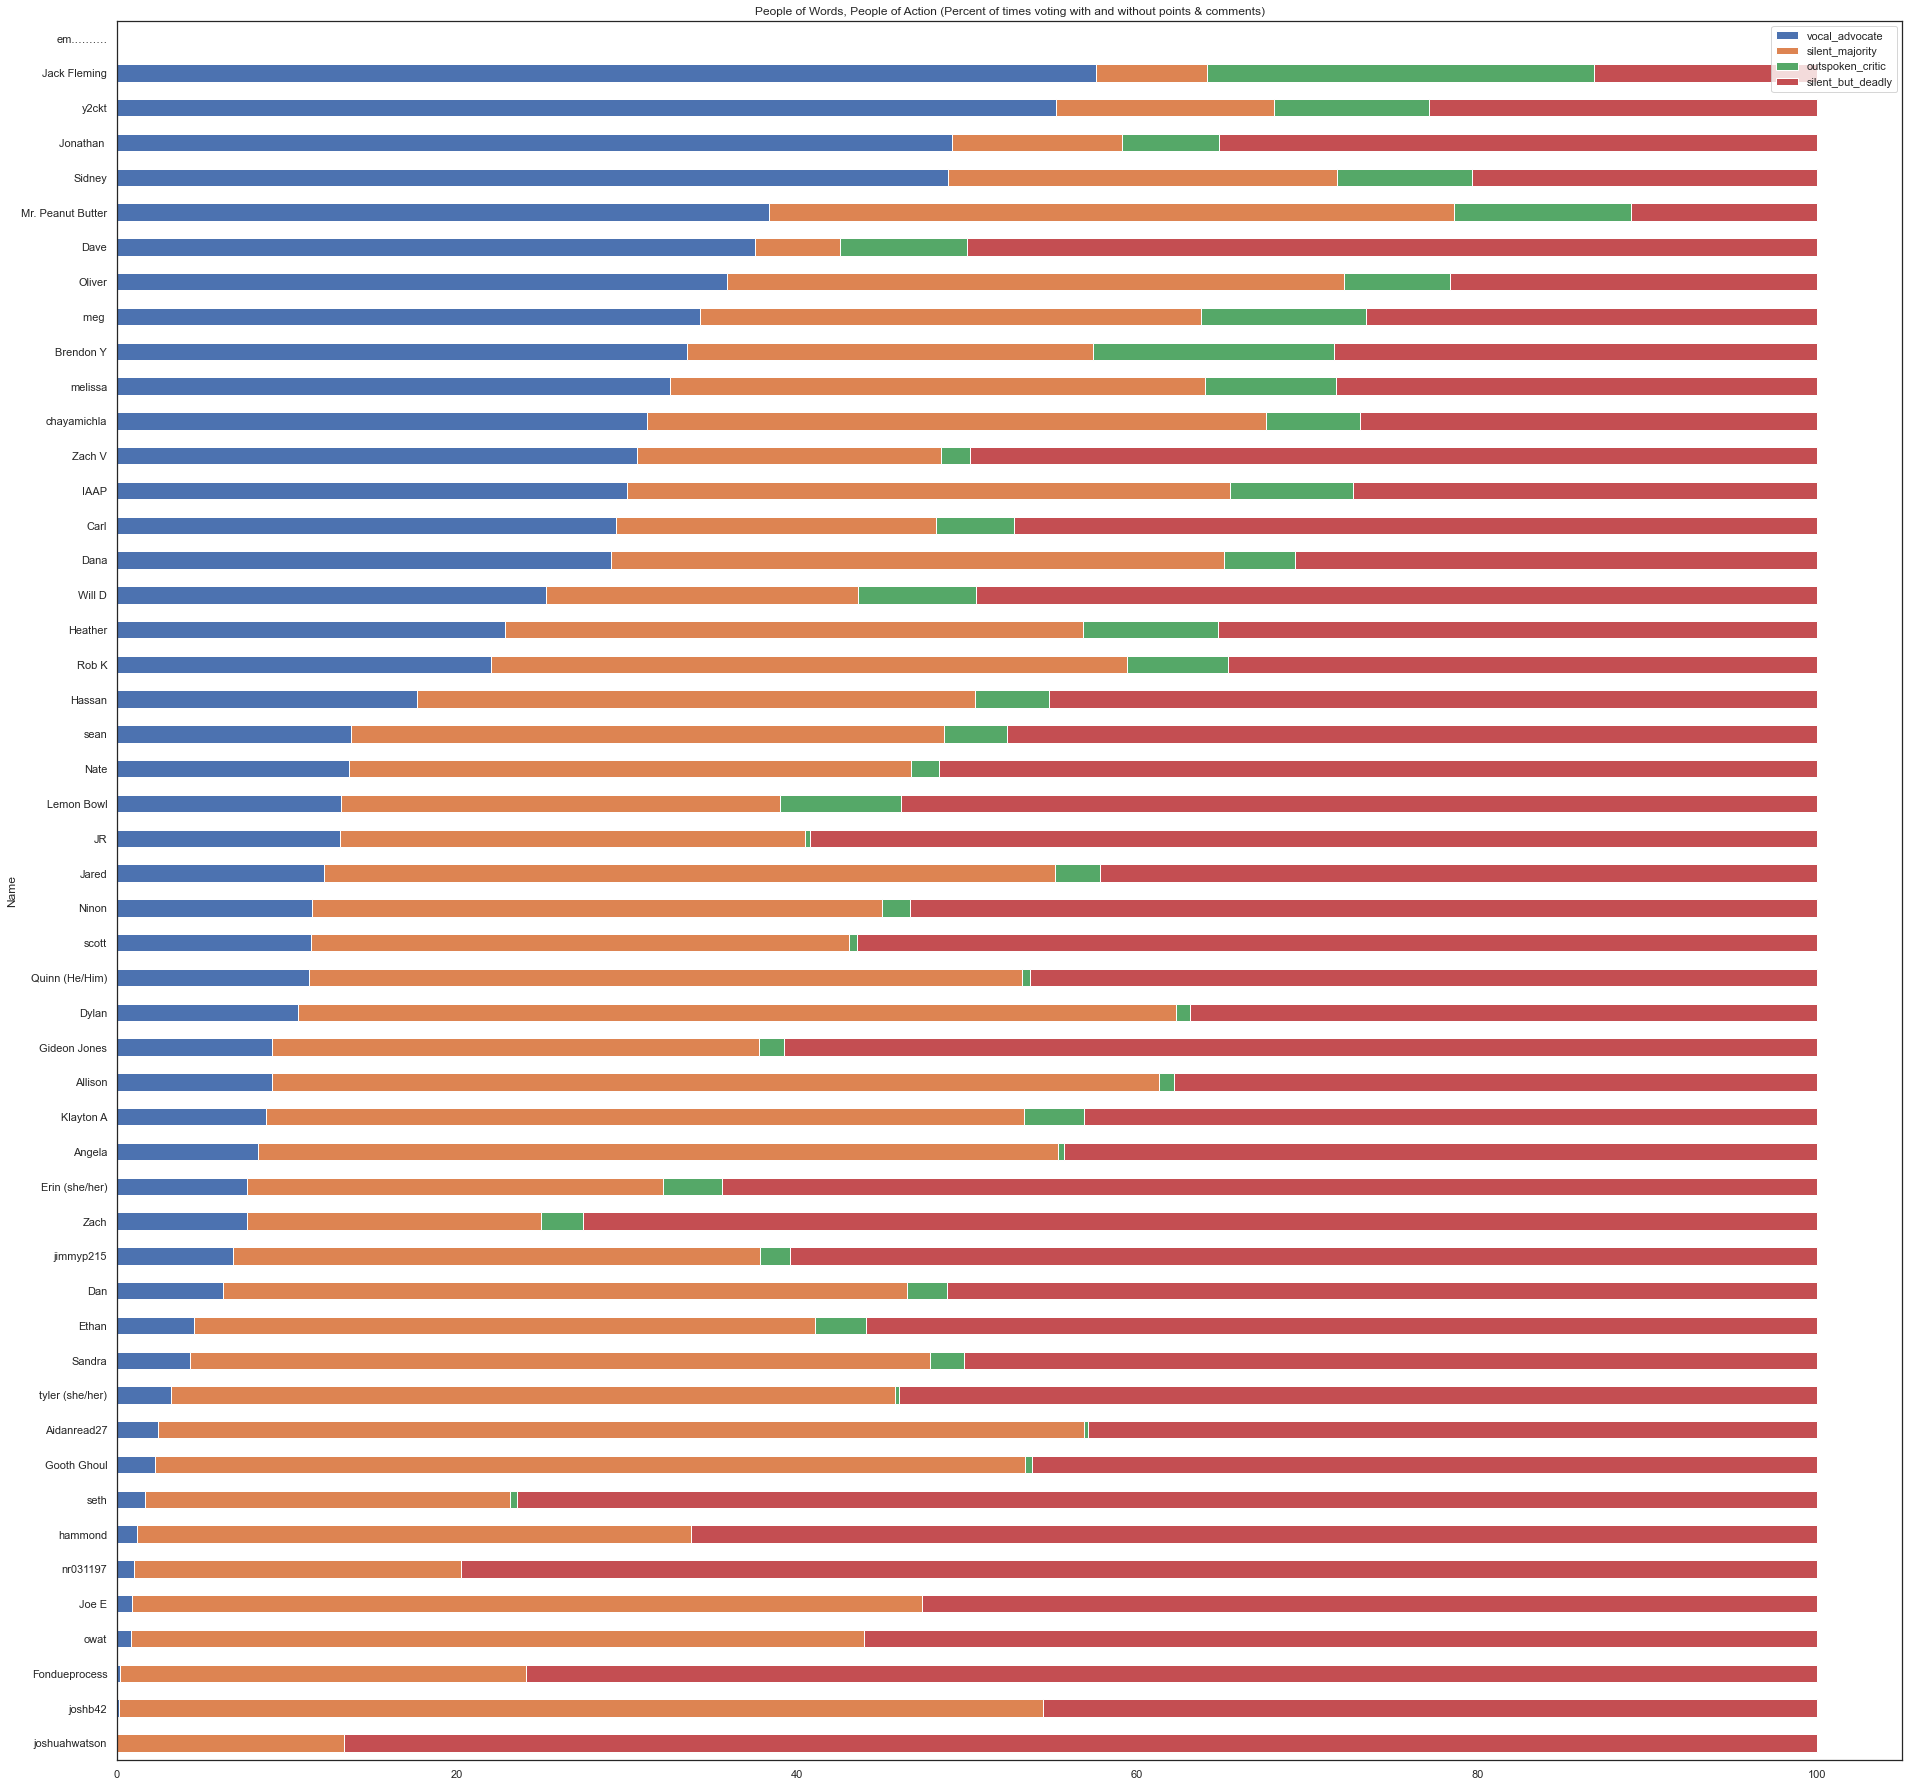

In [75]:
ax = competitor_engagement.plot.barh(x='Name', y=cols, stacked=True)

plt.title('People of Words, People of Action (Percent of times voting with and without points & comments)')
plt.gcf().set_size_inches(32, 32)

In [76]:
#maybe something here around % with points, and % with comments
#then do a quick clustering based on those two attributes to find voters with like behaviors, 
#absent their actual voting interests
percent_votes_comments = competitor_engagement
percent_votes_comments['Percent_positive']=percent_votes_comments['silent_majority']+percent_votes_comments['vocal_advocate']
percent_votes_comments['Percent_comments']=percent_votes_comments['outspoken_critic']+percent_votes_comments['vocal_advocate']

del percent_votes_comments['vocal_advocate']
del percent_votes_comments['silent_majority']
del percent_votes_comments['outspoken_critic']
del percent_votes_comments['silent_but_deadly']

percent_votes_comments.head()

ID           Name  Percent_positive  \
33  b289f6bd176a46e688e791937178a1c7  joshuahwatson         13.333333   
35  50bcd53a0bf84421a05d12190c08c895        joshb42         54.447853   
4   ac8a680b7955442a80c999deb6aab714  Fondueprocess         24.048096   
46  baa33e187fbc43b98463c10a6e72e50c           owat         43.965517   
29  fe88b3f0df524756b638fe8ea42499e8          Joe E         47.320061   

    Percent_comments  
33          0.000000  
35          0.153374  
4           0.200401  
46          0.862069  
29          0.918836

In [77]:
percent_votes_comments = percent_votes_comments.head(percent_votes_comments.shape[0] -1)

In [78]:
percent_votes_comments = percent_votes_comments.fillna(0)
percent_votes_comments = percent_votes_comments.astype({"Percent_positive":'int', "Percent_comments":'int'}) 

In [79]:
each_participants_points = points_for.groupby(['Name_submitter']).sum()
each_participants_points.rename(columns = {'Name_submitter':'Name'}, inplace = True)
each_participants_points.reset_index()
each_participants_points.head()

Points_Assigned  total_points_cast  percent_share
Name_submitter                                                   
Aidanread27                 999              37940     120.980827
Allison                    1203              38065     142.354829
Angela                      587              36970      72.242381
Brendon Y                   855              38310     101.747234
Carl                        873              38235     108.310011

# 7. Turning comments/votes into Scatterplot  

In [80]:
scatterplot_dataframe1 = pd.merge(percent_votes_comments, each_participants_points[['Points_Assigned']], left_on ='Name', right_on='Name_submitter')

In [81]:
scatterplot_dataframe1.head()

ID           Name  Percent_positive  \
0  b289f6bd176a46e688e791937178a1c7  joshuahwatson                13   
1  50bcd53a0bf84421a05d12190c08c895        joshb42                54   
2  ac8a680b7955442a80c999deb6aab714  Fondueprocess                24   
3  baa33e187fbc43b98463c10a6e72e50c           owat                43   
4  fe88b3f0df524756b638fe8ea42499e8          Joe E                47   

   Percent_comments  Points_Assigned  
0                 0               93  
1                 0              737  
2                 0              410  
3                 0              182  
4                 0             1020

In [82]:
#vote_and_submissions.groupby(['Name_voter', 'Name_submitter']).count()
rounds_participated = submissions.groupby(['Name']).count()
rounds_participated.rename(columns={'Spotify URI': 'Num_rounds'}, inplace=True)
del rounds_participated['Submitter ID']
del rounds_participated['Created']
del rounds_participated['Comment']
del rounds_participated['Round ID']
del rounds_participated['ID']

scatterplot_dataframe1 = scatterplot_dataframe1.merge(rounds_participated[['Num_rounds']], on ='Name')
scatterplot_dataframe1['avg_per_round']=scatterplot_dataframe1['Points_Assigned']/scatterplot_dataframe1['Num_rounds']
scatterplot_dataframe1.head()

ID           Name  Percent_positive  \
0  b289f6bd176a46e688e791937178a1c7  joshuahwatson                13   
1  50bcd53a0bf84421a05d12190c08c895        joshb42                54   
2  ac8a680b7955442a80c999deb6aab714  Fondueprocess                24   
3  baa33e187fbc43b98463c10a6e72e50c           owat                43   
4  fe88b3f0df524756b638fe8ea42499e8          Joe E                47   

   Percent_comments  Points_Assigned  Num_rounds  avg_per_round  
0                 0               93           2      46.500000  
1                 0              737          16      46.062500  
2                 0              410          14      29.285714  
3                 0              182           3      60.666667  
4                 0             1020          18      56.666667

In [83]:
positive_mean = scatterplot_dataframe1['Percent_positive'].mean()
comments_mean = scatterplot_dataframe1['Percent_comments'].mean()

## 7.1 Creating kmeans clusters on habits 

In [84]:
# K-Means clustering to find 2 clusters based on comments and votes
kmeans = KMeans(n_clusters=4, random_state=0).fit(scatterplot_dataframe1[["Percent_positive", "Percent_comments"]])


# See the cluster label for each data point / Group label of each voter
kmean_labels = kmeans.labels_
kmeans.labels_



array([0, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1], dtype=int32)

In [85]:
# Identifying the (final) cluster centroids
kmeans.cluster_centers_

array([[27.        ,  4.77777778],
       [68.        , 60.4       ],
       [57.53846154, 36.69230769],
       [49.13636364,  9.31818182]])

In [86]:
labels = scatterplot_dataframe1['Name'].to_numpy()
labels

array(['joshuahwatson', 'joshb42', 'Fondueprocess', 'owat', 'Joe E',
       'nr031197', 'hammond', 'seth', 'Gooth Ghoul', 'Aidanread27',
       'tyler (she/her)', 'Sandra', 'Ethan', 'Dan', 'jimmyp215', 'Zach',
       'Erin (she/her)', 'Angela', 'Klayton A', 'Allison', 'Gideon Jones',
       'Dylan', 'Quinn (He/Him)', 'scott', 'Ninon', 'Jared', 'JR',
       'Lemon Bowl', 'Nate', 'sean', 'Hassan', 'Rob K', 'Heather',
       'Will D', 'Dana', 'Carl', 'IAAP', 'Zach V', 'chayamichla',
       'melissa', 'Brendon Y', 'meg ', 'Oliver', 'Dave',
       'Mr. Peanut Butter', 'Sidney', 'Jonathan ', 'y2ckt',
       'Jack Fleming'], dtype=object)

## 7.2 Graphing with cluster colors 

<IPython.core.display.Javascript object>


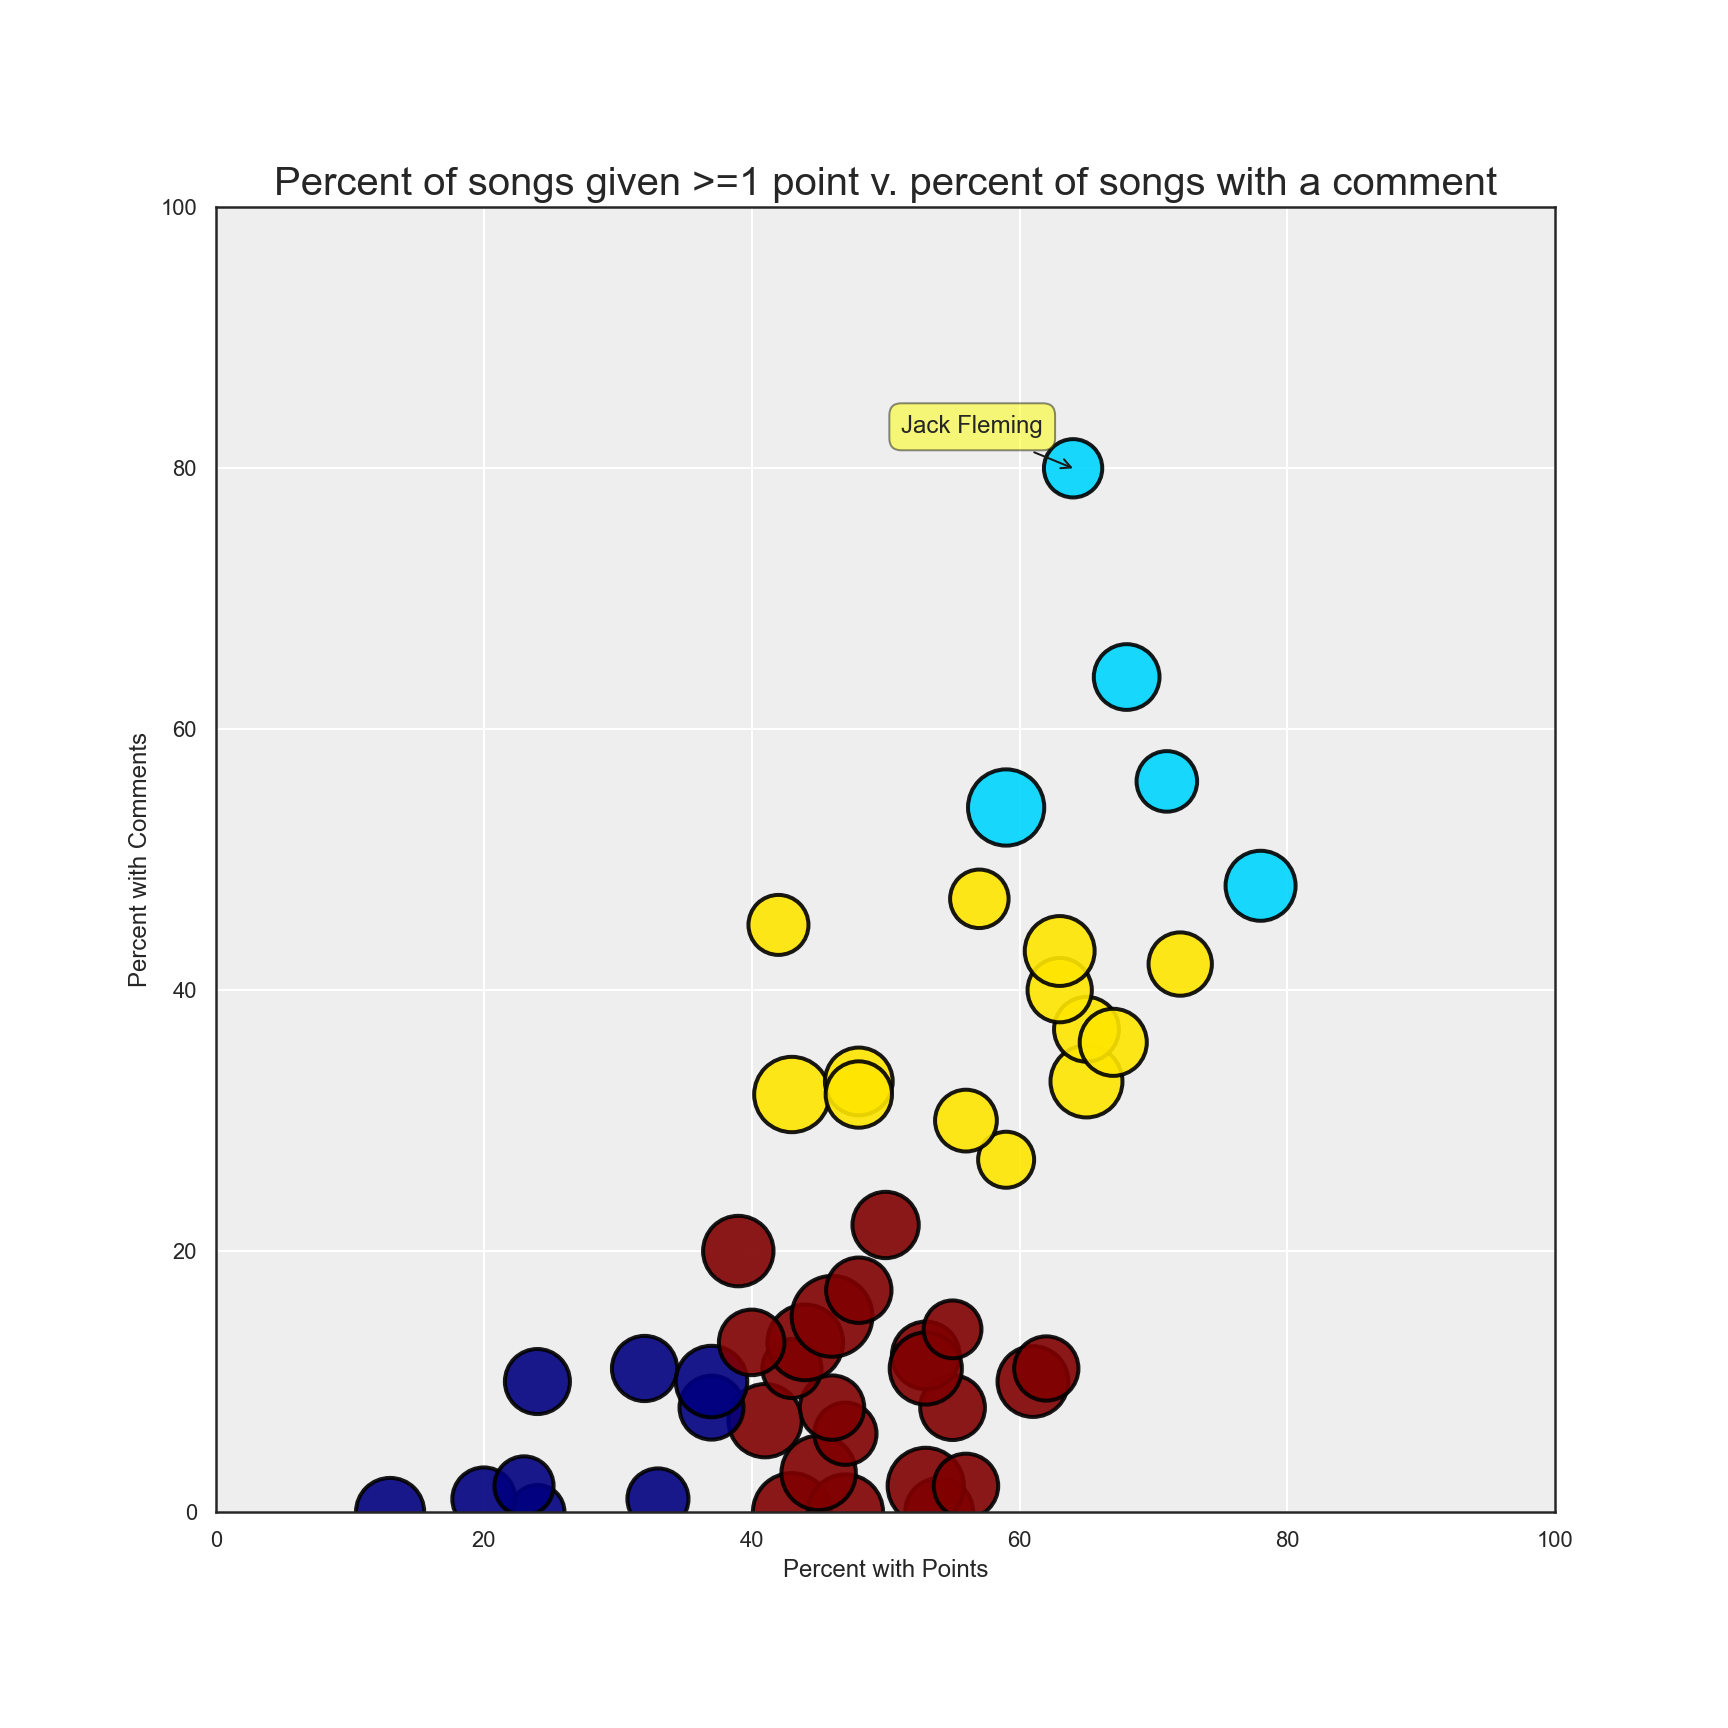

In [87]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
N = len(competitors)-1

scatter = ax.scatter(x=scatterplot_dataframe1.Percent_positive,
                     y=scatterplot_dataframe1.Percent_comments,
                     s=25*scatterplot_dataframe1.avg_per_round,
                     c=kmean_labels,
                     alpha=0.9,
                     cmap=plt.cm.jet,
                     linewidths=2,
                     edgecolors='black')
ax.grid(color='white', linestyle='solid')
sns.set_theme(style="white")


ax.set_title("Percent of songs given >=1 point v. percent of songs with a comment", size=20)

mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(scatterplot_dataframe1["Name"][sel.index]))    

    
plt.gcf().set_size_inches(12, 12)
plt.xlabel('Percent with Points')
plt.ylabel('Percent with Comments')
plt.xlim([0, 100])
plt.ylim([0, 100])


plt.ion
plt.isinteractive = True
#mpld3.display()

# 8. Establishing Points-Above-Replacement-Submission

In [88]:
competitor_PARS = competitors
competitor_PARS.head()

ID            Name  vocal_advocate  \
0  f99a5821c49d4a8eaa40dbc457beda3c    Jack Fleming       57.582938   
1  e595e8971f0d4500b512f788f52e60da  Quinn (He/Him)       11.297539   
2  e2c317228ea34373a515e66d3a20c482           y2ckt       55.232558   
3  2a1b637e09834879baf13d6cc3459270         hammond        1.164725   
4  ac8a680b7955442a80c999deb6aab714   Fondueprocess        0.200401   

   silent_majority  outspoken_critic  silent_but_deadly  
0         6.516588         22.748815          13.151659  
1        41.946309          0.447427          46.308725  
2        12.790698          9.156977          22.819767  
3        32.612313          0.000000          66.222962  
4        23.847695          0.000000          75.951904

In [89]:
# points above replacement submission
    #PARS
    #Look at the median submission for each round
    #subtract that from your submission each round
    #sum per voter
    
#need to do both:
    #median submission per round
    #which competitor was in each round

In [90]:
round_song_sum = round_song_sum.merge(num_per_round, how='left', on=['Round_ID'])


round_song_sum.reset_index()

#num_per_round now shows the number of songs submitted in each round. 
#now, we merge that with round_song_sum so we can identify how many to .nlargest()


####n.largest()????

round_song_sum.head()

#here we gotta figure out how to essentially tag each song submitted with position in the submissions per that round

# then, see who what percent of each person's votes went to a top 3 song and a bottom 3 song 
# by incorporating the votes_and_submission table

#round_song_sum = round_song_sum.groupby(['Round_ID', 'Name_submitter']).nlargest()
#round_song_sum.head()

Round_ID  Points_Received  count_songs  \
0  09502eae8e58411fbe1f640e2d5d837b               32           40   
1  09502eae8e58411fbe1f640e2d5d837b               40           40   
2  09502eae8e58411fbe1f640e2d5d837b               31           40   
3  09502eae8e58411fbe1f640e2d5d837b               59           40   
4  09502eae8e58411fbe1f640e2d5d837b               20           40   

   Jack Fleming  Quinn (He/Him)  y2ckt  hammond  Fondueprocess  Heather  \
0            35              16     28       12              0       25   
1            35              16     28       12              0       25   
2            35              16     28       12              0       25   
3            35              16     28       12              0       25   
4            35              16     28       12              0       25   

   Oliver  ...  Dylan  Hassan  sean  Carl  Angela  jimmyp215  owat  Sidney  \
0      28  ...     24      24     0    19       0         22     0      38   
1      28  ...     24      24     0    19       0         22     0      38   
2      28  ...     24      24     0    19       0         22     0      38   
3      28  ...     24      24     0    19       0         22     0      38   
4      28  ...     24      24     0    19       0         22     0      38   

   Dave  Ninon  
0     0     20  
1     0     20  
2     0     20  
3     0     20  
4     0     20  

[5 rows x 53 columns]

In [91]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,matplotlib,seaborn,nltk,sklearn,mpld3,mplcursors,spotipy,plotly,watermark

print (" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.30.1

pandas    : 1.4.2
numpy     : 1.21.5
matplotlib: 3.5.1
seaborn   : 0.11.2
nltk      : 3.7
sklearn   : 1.0.2
mpld3     : 0.5.8
mplcursors: 0.5.1
spotipy   : 2.20.0
plotly    : 5.6.0
watermark : 2.3.1

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

 
Last updated: Sun Oct 02 2022 20:57:28EDT

